In [52]:
%matplotlib inline
from comet_ml import Experiment
import numpy as np
import scipy.spatial
import pandas as pd
import comet_ml
import sklearn.decomposition
import matplotlib.pyplot as plt
import seaborn as sb
import keras
from utils.readProfiles import readMergedProfiles
import linear_cca 
import seaborn as sns
# import multimodal_data

In [11]:
ls

CCA-analysis.ipynb              linear_cca.py
CP-from-to-GE.ipynb             multimodal_data.py
DNN-prediction.ipynb            preprocess_datasets.ipynb
GeneVsCPfeature-analysis.ipynb  results-Treatment_1t0121.csv
LICENSE                         temp_weights.h5
README.md                       tsne.py
__pycache__/                    utils/
deepCCA-analysis.ipynb


# Load data
- CDRPBIO-BBBC036-Bray (U2OS)
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (21122, 1804)   l1k:  (21983, 983)
    * Avg replicate: cp: ~8 , l1k: ~1
    * Treatment Level Shapes (nSamples x nFeatures): (2240, 1786) (21781, 981) Merged Profiles Shape: (1921, 2766)
    
    
- LUAD-BBBC041-Caicedo (A549)
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (6144, 1814)   l1k:  (4232, 1032)
    * Avg replicate: cp: ~10 , l1k: ~8
    * Treatment Level Shapes (nSamples x nFeatures): (593, 1786) (529, 979) Merged Profiles Shape: (525, 2764)
    
    
- TA-ORF-BBBC037-Rohban (U2OS)
    * Replicate Level Shapes (nSamples x nFeatures): cp:  (1920, 1804)   l1k:  (729, 1018)
    * Avg replicate: cp: ~10 , l1k: ~3
    * Treatment Level Shapes (nSamples x nFeatures): (327, 1788) (226, 980) Merged Profiles Shape: (321, 2767)

In [29]:
# dataset options: 'CDRP' , 'LUAD', 'TAORF'
dataset='LUAD';

# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'

# n of samples for replicate picking options: numbers or, 'max'
nRep=4

mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features,pertColName=readMergedProfiles(dataset,profileType,nRep)

# l1k=mergProf_repLevel[[pertColName]+l1k_features.tolist()]
# cp=mergProf_repLevel[[pertColName]+cp_features.tolist()]

l1k=mergProf_treatLevel[['Allele']+l1k_features.tolist()]
cp=mergProf_treatLevel[['Allele']+cp_features.tolist()]
# cols2remove=[i for i in cp.columns.tolist() if cp[i].isnull().sum(axis=0)/cp.shape[0]>0.05]
cols2removeCP=[i for i in cp.columns.tolist() if cp[i].isnull().sum(axis=0)>0]
print(cols2removeCP)
cp=cp.drop(cols2removeCP, axis=1);
cp = cp.interpolate()

cols2removeGE=[i for i in l1k.columns.tolist() if l1k[i].isnull().sum(axis=0)>0]
print(cols2removeGE)


/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (1023,1028) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Replicate Level Shapes (nSamples x nFeatures): cp:  (6144, 322)   l1k:  (4232, 1032)
Treatment Level Shapes (nSamples x nFeatures): (593, 294) (529, 979) Merged Profiles Shape: (525, 1272)
[]
[]


In [17]:
# cp.groupby(pertColName).size()

In [18]:
import tensorflow as tf
class MultimodalDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, modA, modB,cycleEnable, batch_size=32):
        'Initialization'
        self.batch_size = batch_size
        self.modA = modA
        self.modB = modB
        self.classes = set( modA["Allele"].unique()).intersection( modB["Allele"].unique() )
        self.classes = list(self.classes)
        self.create_samples()
        self.cycle=cycleEnable
        
    def create_samples(self):
        dataA = []
        dataB = []
        classes = []
        # Generate all combinations of A and B with the same label
        for cl in self.classes:
            for idx, rowA in self.modA[self.modA["Allele"] == cl].iterrows():
                for jdx, rowB in self.modB[self.modB["Allele"] == cl].iterrows():
                    dataA.append(np.reshape(np.asarray(rowA)[1:], (1,self.modA.shape[1]-1)))
                    dataB.append(np.reshape(np.asarray(rowB)[1:], (1,self.modB.shape[1]-1)))
                    classes.append(cl)
        self.X = np.concatenate(dataA)
        self.Y = np.concatenate(dataB)
        self.Y2 = np.concatenate(dataA)
        self.Z = classes
        print("Total pairs:", len(dataA), self.X.shape, self.Y.shape)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.modA) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Initialization
        index = np.arange(0,self.X.shape[0])
        np.random.shuffle(index)
        X = self.X[index[0:self.batch_size], :]
        Y = self.Y[index[0:self.batch_size], :]
        if self.cycle:
            Y2 = self.X[index[0:self.batch_size], :]
            return X, [Y,Y2]
        else:
            
            return X,Y
    
def mp2ge_net(in_size, out_size):
#     in_size=in_size0[0]
    inLayer = keras.layers.Input([in_size])
    net = keras.layers.Dense(in_size, activation="relu")(inLayer)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dense(in_size//2, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size//4, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size, activation=None)(net)
    return inLayer, net

def mp2ge(inLayer,in_size, out_size):
#     in_size=in_size0[0]
#     inLayer = keras.layers.Input([in_size])
    net = keras.layers.Dense(in_size, activation="relu")(inLayer)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dense(in_size//2, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size//4, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size, activation='tanh')(net)
    return net

def ge2mp_net(inLayer, in_size, out_size):
#     in_size=in_size0[0]
#     inLayer = tf.keras.layers.Input([in_size])
    net = keras.layers.Dense(in_size, activation="relu")(inLayer)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dense(in_size*2, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size*4, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(out_size, activation='tanh')(net)
    return net


In [19]:
from keras_contrib.layers import InstanceNormalization
def ck(x, k, use_normalization):
    x = keras.layers.Conv1D(filters=k, kernel_size=4, strides=2, padding='same')(x)
    # Normalization is not done on the first discriminator layer
    if use_normalization:
        x = InstanceNormalization(axis=2, center=True, epsilon=1e-5)(x, training=True)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

def modelDiscriminator(input_img, name=None):
    # Specify input 
#     input_img = keras.layers.Input(shape=[img_shape,1])
#     input_img1=keras.backend.expand_dims(input_img,axis=-1)
    # Layer 1 (#Instance normalization is not used for this layer)
    x = ck(input_img, 64, False)
    # Layer 2
    x = ck(x, 128, True)
    # Layer 3
    x = ck(x, 256, True)
    # Layer 4
    x = ck(x, 512, True)
    # Output layer
    use_patchgan=False
    if use_patchgan:
        x = keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, padding='same')(x)
    else:
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1)(x)
    x = keras.layers.Activation('sigmoid')(x)
#     print(input_img,x)
    return Model(inputs=input_img, outputs=x, name=name)

def modelDiscriminator3(in_size, name=None):
    inLayer2 = keras.layers.Input([in_size])
    inputt=keras.layers.Reshape(in_size + (1, ), input_shape=in_size)(inLayer2)
    x = ck(inputt, 64, False)
    # Layer 2
    x = ck(x, 128, True)
    # Layer 3
    x = ck(x, 256, True)
    # Layer 4
    x = ck(x, 512, True)
    # Output layer
    use_patchgan=False
    if use_patchgan:
        x = keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, padding='same')(x)
    else:
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1)(x)
    net = keras.layers.Activation('sigmoid')(x)
    return inLayer2,net

def modelDiscriminator2(in_size, name=None):
    inLayer2 = keras.layers.Input([in_size])
    net = keras.layers.Dense(64, activation="relu")(inLayer2)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dense(128, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(512, activation="relu")(net)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(1, activation=None)(net)
    net = keras.layers.Activation('sigmoid')(net)
    return inLayer2,net


In [ ]:
# configuration = tf.ConfigProto()
# configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "3"
# session = tf.Session(config = configuration)

# tf.keras.backend.set_session(session)
# inLayer, net= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
# model = tf.keras.Model(inLayer, net)
# model.compile(optimizer='adam', loss='mean_absolute_error')
# cycleEnable=False
# dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
# dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)
# model.fit_generator(dgen_train, epochs=100, verbose=1,validation_data=dgen_test)
# predicted_ge = model.predict(np.asarray(acp_test)[:,1:])
scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)

In [ ]:
predicted_ge.shape

In [ ]:

# params = dpmodel.config["train"]["model"]["params"]
# experiment.log_parameters(params)

In [ ]:
acp_train.columns[1:]

In [ ]:
uniAls=acp_train['Allele'].unique()
x=uniAls[np.random.randint(uniAls.shape[0],size=50)]
acp_train.loc[acp_train['Allele']==x[0],acp_train.columns[1:]].values

In [ ]:
 (144*200)/384

In [ ]:
(5*1024*20)/75

In [ ]:

# Cycle
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.Session(config = configuration)

tf.keras.backend.set_session(session)
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
#     input_img = keras.layers.Input(shape=[img_shape,1])
#     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
#     D_ge_0=modelDiscriminator2(image_ge)
image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
image_mp, guess_mp=modelDiscriminator2(acp_train.shape[1]-1)

#     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

#     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
#     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

#     guess_ge=D_ge_1(image_ge)
D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

D_mp = Model(inputs=image_mp, outputs=guess_mp, name='D_mp_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_mp.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

#     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

# real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
synthetic_ge= mp2ge(image_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

G_A2B=Model(inputs=image_mp, outputs=synthetic_ge, name='g_A2B')

#     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
# identity mapping
#     image_ge_i=G_A2B(image_ge)
synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
G_B2A=Model(inputs=image_ge, outputs=synthetic_mp, name='g_B2A')

# image_ge_i=G_A2B(synthetic_mp)
#     print(image_ge,synthetic_mp,image_ge_i)
#     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

#     synthetic_ge = mp2ge_net(real_mp)
reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
reconstructed_ge = mp2ge(synthetic_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

valid_ge=D_ge(synthetic_ge)
valid_mp=D_mp(synthetic_mp)
#     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
#     model_outputs = [reconstructed_mp,image_ge_i]
model_outputs = [reconstructed_mp,reconstructed_ge, valid_mp, valid_ge]
# print(real_mp, model_outputs)
model_combined = Model(inputs=[image_mp,image_ge], outputs=model_outputs)
compile_losses=['mae','mae','mse','mse']
compile_weights=[10,10,1,1]
model_combined.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

#     cycleEnable=True    

#     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
#     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

#     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

#     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
#     callbacks = [cb, callback_csv]
#     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
#                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

epochs=1
steps=5
allelePairing=False
uniAls=acp_train['Allele'].unique()
for epoch in range(epochs):        
    batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
    for batch_i in range(steps):
        if allelePairing:
            im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;

            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_A=real_images_A[0:4,:]
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)
            real_images_B=real_images_B[0:8,:]
        else:
            randRows1=np.random.randint(acp_train.shape[0],size=20)
            randRows2=np.random.randint(al1k_train.shape[0],size=20)
            im_A_0=acp_train.loc[randRows1,acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[randRows2,al1k_train.columns[1:]].values;  

            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)

        # ======= Discriminator training ==========
#         print(im_A_0.shape)
        synthetic_images_B = G_A2B.predict(real_images_A,steps=1)

        batch_size=im_B_0.shape[0]
        label_shape = (batch_size,) + D_ge.output_shape[1:]
        ones = np.ones(shape=label_shape) 
        zeros = ones * 0    

        synthetic_images_A = G_B2A.predict(real_images_B)
#             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
#             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
        DA_loss_real = D_mp.train_on_batch(x=real_images_A, y=ones)
#       y=tf.ones_like(real_images_B)
        DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
        DA_loss_synthetic = D_mp.train_on_batch(x=synthetic_images_A, y=zeros)
        DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
        DA_loss = DA_loss_real + DA_loss_synthetic
        DB_loss = DB_loss_real + DB_loss_synthetic
        D_loss = DA_loss + DB_loss            


        # ======= Generator training ==========
        target_data=[real_images_A,real_images_B[0:real_images_A.shape[0],:],ones[0:real_images_A.shape[0]],ones[0:real_images_A.shape[0]]]
        G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

        gA_d_loss_synthetic = G_loss[1]
        gB_d_loss_synthetic = G_loss[2]
        reconstruction_loss_A = G_loss[3]
        reconstruction_loss_B = G_loss[4]

        print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

        predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
        #     print(predicted_ge.shape, al1k_test.shape)
        #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
        cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
        print(cc)


In [ ]:
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.Session(config = configuration)

tf.keras.backend.set_session(session)
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
#     input_img = keras.layers.Input(shape=[img_shape,1])
#     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
#     D_ge_0=modelDiscriminator2(image_ge)
image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
image_mp, guess_mp=modelDiscriminator2(acp_train.shape[1]-1)

#     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

#     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
#     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

#     guess_ge=D_ge_1(image_ge)
D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

D_mp = Model(inputs=image_mp, outputs=guess_mp, name='D_mp_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_mp.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

#     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

# real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
synthetic_ge= mp2ge(image_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

G_A2B=Model(inputs=image_mp, outputs=synthetic_ge, name='g_A2B')

#     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
# identity mapping
#     image_ge_i=G_A2B(image_ge)
synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
G_B2A=Model(inputs=image_ge, outputs=synthetic_mp, name='g_B2A')

# image_ge_i=G_A2B(synthetic_mp)
#     print(image_ge,synthetic_mp,image_ge_i)
#     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

#     synthetic_ge = mp2ge_net(real_mp)
reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
reconstructed_ge = mp2ge(synthetic_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

valid_ge=D_ge(synthetic_ge)
valid_mp=D_mp(synthetic_mp)
#     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
#     model_outputs = [reconstructed_mp,image_ge_i]
model_outputs = [reconstructed_mp,reconstructed_ge, valid_mp, valid_ge]
# print(real_mp, model_outputs)
model_combined = Model(inputs=[image_mp,image_ge], outputs=model_outputs)
compile_losses=['mae','mae','mse','mse']
compile_weights=[10,10,1,1]
model_combined.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

#     cycleEnable=True    

#     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
#     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

#     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

#     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
#     callbacks = [cb, callback_csv]
#     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
#                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

epochs=2
steps=5
allelePairing=False
uniAls=acp_train['Allele'].unique()
for epoch in range(epochs):        
    batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
    for batch_i in range(steps):
        if allelePairing:
            im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;

            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_A=real_images_A[0:4,:]
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)
            real_images_B=real_images_B[0:8,:]
        else:
            batch_size=500;
#             randRows1=np.random.randint(acp_train.shape[0],size=batch_size)
#             randRows2=np.random.randint(al1k_train.shape[0],size=batch_size)
            randRows1=np.random.choice(acp_train.index.tolist(),size=batch_size)
            randRows2=np.random.choice(al1k_train.index.tolist(),size=batch_size)
            im_A_0=acp_train.loc[randRows1,acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[randRows2,al1k_train.columns[1:]].values;  

            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)

        # ======= Discriminator training ==========
#         print(im_A_0.shape)
        synthetic_images_B = G_A2B.predict(real_images_A)

        batch_size=im_B_0.shape[0]
        label_shape = (batch_size,) + D_ge.output_shape[1:]
        ones = np.ones(shape=label_shape) 
        zeros = ones * 0    

#             synthetic_images_A = self.G_B2A.predict(real_images_B)
#             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
#             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
#             DA_loss_real = self.D_ge.train_on_batch(x=real_images_A, y=ones)
#       y=tf.ones_like(real_images_B)
        DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
#             DA_loss_synthetic = self.D_ge.train_on_batch(x=synthetic_images_A, y=zeros)
        DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
#             DA_loss = DA_loss_real + DA_loss_synthetic
        DB_loss = DB_loss_real + DB_loss_synthetic
#             D_loss = DA_loss + DB_loss            


        # ======= Generator training ==========
        target_data=[real_images_A,real_images_B[0:real_images_A.shape[0],:],ones[0:real_images_A.shape[0]],ones[0:real_images_A.shape[0]]]
        G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

        gA_d_loss_synthetic = G_loss[1]
        gB_d_loss_synthetic = G_loss[2]
        reconstruction_loss_A = G_loss[3]
        reconstruction_loss_B = G_loss[4]

        print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

        predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
        #     print(predicted_ge.shape, al1k_test.shape)
        #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
        cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
        print(cc)


In [ ]:
acp_test.isnull().sum().sum()

In [ ]:
acp_train.index

In [ ]:
real_images_A

In [ ]:
D_ge.output_shape[1:]

Complete CycleGAN

In [ ]:
reconstructed_ge

In [ ]:
real_images_A.shape

In [ ]:
#### experiment = comet_ml.Experiment(
#         api_key='wRu2GizrrhvMrx22c5346ocuq',
#         project_name='Rosetta'
#     )

# mp to gene expression
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.Session(config = configuration)

tf.keras.backend.set_session(session)
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
#     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
#     input_img = keras.layers.Input(shape=[img_shape,1])
#     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
#     D_ge_0=modelDiscriminator2(image_ge)
image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
#     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

#     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
#     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

#     guess_ge=D_ge_1(image_ge)
D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

#     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
G_A2B=Model(inputs=real_mp, outputs=synthetic_ge, name='g_A2B')
#     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
# identity mapping
#     image_ge_i=G_A2B(image_ge)
synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
image_ge_i=G_A2B(synthetic_mp)
#     print(image_ge,synthetic_mp,image_ge_i)
#     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

#     synthetic_ge = mp2ge_net(real_mp)
reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)

valid_ge=D_ge(synthetic_ge)
#     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
#     model_outputs = [reconstructed_mp,image_ge_i]
model_outputs = [reconstructed_mp,valid_ge]
# print(real_mp, model_outputs)
model_combined = Model(inputs=[real_mp,image_ge], outputs=model_outputs)
compile_losses=['mae','mse']
compile_weights=[10,1]
model_combined.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

#     cycleEnable=True    

#     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
#     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

#     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

#     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
#     callbacks = [cb, callback_csv]
#     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
#                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

epochs=50
steps=100
uniAls=acp_train['Allele'].unique()
for epoch in range(epochs):        
    batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
    for batch_i in range(steps):
        im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
        im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;
        real_images_A=np.copy(im_A_0)
        np.random.shuffle(real_images_A)
        real_images_A=real_images_A[0:4,:]
        real_images_B=np.copy(im_B_0)
        np.random.shuffle(real_images_B)
        real_images_B=real_images_B[0:8,:]

        # ======= Discriminator training ==========
#         print(im_A_0.shape)
        synthetic_images_B = G_A2B.predict(real_images_A,steps=2)
    
        batch_size=im_B_0.shape[0]
        label_shape = (batch_size,) + D_ge.output_shape[1:]
        ones = np.ones(shape=label_shape) 
        zeros = ones * 0    
    
#             synthetic_images_A = self.G_B2A.predict(real_images_B)
#             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
#             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
#             DA_loss_real = self.D_ge.train_on_batch(x=real_images_A, y=ones)
#       y=tf.ones_like(real_images_B)
        DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
#             DA_loss_synthetic = self.D_ge.train_on_batch(x=synthetic_images_A, y=zeros)
        DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
#             DA_loss = DA_loss_real + DA_loss_synthetic
        DB_loss = DB_loss_real + DB_loss_synthetic
#             D_loss = DA_loss + DB_loss            


        # ======= Generator training ==========
        target_data=[real_images_A,ones[0:real_images_A.shape[0]]]
        G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

        gA_d_loss_synthetic = G_loss[1]
        gB_d_loss_synthetic = G_loss[2]
        reconstruction_loss_A = G_loss[3]
        reconstruction_loss_B = G_loss[4]

        print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

        predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
        #     print(predicted_ge.shape, al1k_test.shape)
        #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
        cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
        print(cc)

In [ ]:
print(real_images_B[0:im_A_0.shape[0],:].shape)

In [ ]:
predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
#     print(predicted_ge.shape, al1k_test.shape)
#     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
print(cc)

In [ ]:
predicted_ge.shape

In [ ]:
batch_of_alleles[batch_i]

In [ ]:
synthetic_images_B.shape

In [ ]:
real_images_A.shape

In [ ]:
im_A_0.shape

In [ ]:
batch_i

In [ ]:
np.random.shuffle(im_A_0)

In [7]:
# from keras.engine.topology import Network
def nnTransformWithCycleAndDis(al1k_train,acp_train,al1k_test,acp_test):
    experiment = comet_ml.Experiment(
            api_key='wRu2GizrrhvMrx22c5346ocuq',
            project_name='Rosetta'
        )
    # mp to gene expression
    configuration = tf.ConfigProto()
    configuration.gpu_options.allow_growth = True
    configuration.gpu_options.visible_device_list = "0"
    session = tf.Session(config = configuration)

    tf.keras.backend.set_session(session)
    #     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
    #     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
    #     input_img = keras.layers.Input(shape=[img_shape,1])
    #     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
    #     D_ge_0=modelDiscriminator2(image_ge)
    image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
    #     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

    #     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
    #     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

    #     guess_ge=D_ge_1(image_ge)
    D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
    lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
    D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

    #     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

    real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
    G_A2B=Model(inputs=real_mp, outputs=synthetic_ge, name='g_A2B')
    #     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
    # identity mapping
    #     image_ge_i=G_A2B(image_ge)
    synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
    image_ge_i=G_A2B(synthetic_mp)
    #     print(image_ge,synthetic_mp,image_ge_i)
    #     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

    #     synthetic_ge = mp2ge_net(real_mp)
    reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)

    valid_ge=D_ge(synthetic_ge)
    #     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
    #     model_outputs = [reconstructed_mp,image_ge_i]
    model_outputs = [reconstructed_mp,valid_ge]
    # print(real_mp, model_outputs)
    model_combined = Model(inputs=[real_mp,image_ge], outputs=model_outputs)
    compile_losses=['mae','mse']
    compile_weights=[10,1]
    model_combined.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

    #     cycleEnable=True    

    #     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
    #     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

    #     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

    #     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
    #     callbacks = [cb, callback_csv]
    #     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
    #                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

    epochs=50
    steps=100
    uniAls=acp_train['Allele'].unique()
    for epoch in range(epochs):        
        batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
        for batch_i in range(steps):
            im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
            im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;
            real_images_A=np.copy(im_A_0)
            np.random.shuffle(real_images_A)
            real_images_A=real_images_A[0:4,:]
            real_images_B=np.copy(im_B_0)
            np.random.shuffle(real_images_B)
            real_images_B=real_images_B[0:8,:]

            # ======= Discriminator training ==========
    #         print(im_A_0.shape)
            synthetic_images_B = G_A2B.predict(real_images_A,steps=2)

            batch_size=im_B_0.shape[0]
            label_shape = (batch_size,) + D_ge.output_shape[1:]
            ones = np.ones(shape=label_shape) 
            zeros = ones * 0    

    #             synthetic_images_A = self.G_B2A.predict(real_images_B)
    #             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
    #             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
    #             DA_loss_real = self.D_ge.train_on_batch(x=real_images_A, y=ones)
    #       y=tf.ones_like(real_images_B)
            DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
    #             DA_loss_synthetic = self.D_ge.train_on_batch(x=synthetic_images_A, y=zeros)
            DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
    #             DA_loss = DA_loss_real + DA_loss_synthetic
            DB_loss = DB_loss_real + DB_loss_synthetic
    #             D_loss = DA_loss + DB_loss            


            # ======= Generator training ==========
            target_data=[real_images_A,ones[0:real_images_A.shape[0]]]
            G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

            gA_d_loss_synthetic = G_loss[1]
            gB_d_loss_synthetic = G_loss[2]
            reconstruction_loss_A = G_loss[3]
            reconstruction_loss_B = G_loss[4]

            print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

            predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
            #     print(predicted_ge.shape, al1k_test.shape)
            #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
            cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
            print(cc)
    return cc

In [ ]:
valid = np.ones((2,) + (10,1))
valid.shape

In [21]:
from numpy.linalg import inv
# Find the mapping between CP and L1k
def linearTransform(al1k_train,acp_train,al1k_test,acp_test):
#     acp_train=np.concatenate((acp_train,np.ones((acp_train.shape[0],1))),axis=1);
# #     print(acp_test.shape)
#     acp_test=np.concatenate((acp_test,np.ones((acp_test.shape[0],1))),axis=1);
#     print(acp_test.shape)
    A=np.matmul(np.matmul(inv(np.matmul(np.transpose(acp_train),acp_train)),np.transpose(acp_train)),al1k_train)
    pred=np.matmul(acp_test,A)
#     print(pred[0].shape,al1k_test[0].shape)
    cc=scipy.stats.pearsonr(pred[0], al1k_test[0])
#     print(pred,al1k_test.shape,cc)
#     print(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1)),:].shape,al1k_test.shape)
    ccRandom=scipy.stats.pearsonr(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1))], al1k_test[0])
#     print(np.random.choice(np.random.choice(al1k_train.shape[0],1)))
    return cc, ccRandom

In [ ]:
dgen_train = MultimodalDataGenerator(acp_train, al1k_train,True)
np.shape(dgen_train[2])

In [ ]:
acp_test.iloc[:,1:].values.shape

In [ ]:
acp_train.shape

In [ ]:
acp_test;

In [ ]:
# Normalize data
# def z_score(A, model, features):
#     alleles = list(A["Allele"])
#     A = pd.DataFrame(data=model.transform(A[features]), columns=features)
#     A["Allele"] = alleles
#     return A[["Allele"] + features]

# ge_features = [str(i) for i in range(GE.shape[1])]
sc = sklearn.preprocessing.StandardScaler()
# sc_l1k.fit(GE_train[ge_features])
# GE_train = z_score(GE_train, sc_l1k, ge_features)
# GE_test = z_score(GE_test, sc_l1k, ge_features)

# mp_features = [str(i) for i in range(MP.shape[1])]
# sc_cp = sklearn.preprocessing.StandardScaler()
# sc_cp.fit(MP_train[mp_features])
# MP_train = z_score(MP_train, sc_cp, mp_features)
# MP_test = z_score(MP_test, sc_cp, mp_features)

In [ ]:
CP_m.shape

In [ ]:
CP_m.columns.tolist().remove('Allele')

In [ ]:
# al1k_train['Allele'];
# CP_m.iloc[:,1:];
# bb2

In [ ]:
predicted_ge[0].shape

In [ ]:
# cp.groupby('Allele').mean().reset_index()
bb=acp_train.iloc[:,1:].values
bb2=np.concatenate((bb,np.ones((bb.shape[0],1))),axis=1);

In [ ]:
# Res.iloc[10:,:];
print(al1k_test.shape,acp_test.shape)

In [97]:
def cycleGan(al1k_train,acp_train,al1k_test,acp_test):
    experiment = comet_ml.Experiment(
            api_key='wRu2GizrrhvMrx22c5346ocuq',
            project_name='Rosetta'
        )
        # mp to gene expression
    configuration = tf.ConfigProto()
    configuration.gpu_options.allow_growth = True
    configuration.gpu_options.visible_device_list = "0"
    session = tf.Session(config = configuration)

    tf.keras.backend.set_session(session)
    #     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1,1])
    #     image_ge = keras.layers.Input(shape=[al1k_train.shape[1]-1])
    #     input_img = keras.layers.Input(shape=[img_shape,1])
    #     image_ge2 = keras.backend.expand_dims(image_ge,axis=-1)
    #     D_ge_0=modelDiscriminator2(image_ge)
#     image_ge, guess_ge=modelDiscriminator2(al1k_train.shape[1]-1)
#     image_mp, guess_mp=modelDiscriminator2(acp_train.shape[1]-1)

    image_ge, guess_ge=modelDiscriminator3(al1k_train.shape[1]-1)
    image_mp, guess_mp=modelDiscriminator3(acp_train.shape[1]-1)    
    #     D_ge_1=Model(inputs=image_ge, outputs=net, name='dis_B')

    #     image_ge = keras.layers.Input([al1k_train.shape[1]-1])
    #     D_ge_0=modelDiscriminator([al1k_train.shape[1]-1])

    #     guess_ge=D_ge_1(image_ge)
    D_ge = Model(inputs=image_ge, outputs=guess_ge, name='D_ge_model')
    lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
    D_ge.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

    D_mp = Model(inputs=image_mp, outputs=guess_mp, name='D_mp_model')
    lr_D=2e-4;beta_1 = 0.5;beta_2 = 0.999
    D_mp.compile(optimizer=Adam(lr_D,beta_1,beta_2),loss='mse',loss_weights=[0.5])

    #     D_ge_static = Network(inputs=image_ge, outputs=guess_ge, name='D_ge_static_model')

    # real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
    synthetic_ge= mp2ge(image_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

    G_A2B=Model(inputs=image_mp, outputs=synthetic_ge, name='g_A2B')

    #     print(real_mp,synthetic_ge,image_ge,keras.backend.squeeze(image_ge,2))
    # identity mapping
    #     image_ge_i=G_A2B(image_ge)
    synthetic_mp= ge2mp_net(image_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
    G_B2A=Model(inputs=image_ge, outputs=synthetic_mp, name='g_B2A')

    # image_ge_i=G_A2B(synthetic_mp)
    #     print(image_ge,synthetic_mp,image_ge_i)
    #     d_ge_guess_synthetic = D_ge_static(synthetic_ge)

    #     synthetic_ge = mp2ge_net(real_mp)
    reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
    reconstructed_ge = mp2ge(synthetic_mp,acp_train.shape[1]-1, al1k_train.shape[1]-1)

    valid_ge=D_ge(synthetic_ge)
    valid_mp=D_mp(synthetic_mp)
    #     model_outputs = [synthetic_ge, reconstructed_mp,d_ge_guess_synthetic]
    #     model_outputs = [reconstructed_mp,image_ge_i]
    model_outputs = [reconstructed_mp,reconstructed_ge, valid_mp, valid_ge]
    # print(real_mp, model_outputs)
    model_combined = Model(inputs=[image_mp,image_ge], outputs=model_outputs)
    compile_losses=['mae','mae','mse','mse']
    compile_weights=[10,10,1,1]
    model_combined.compile(optimizer=keras.optimizers.sgd(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   

    #     cycleEnable=True    

    #     dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
    #     dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)

    #     cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)

    #     callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
    #     callbacks = [cb, callback_csv]
    #     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=0,\
    #                         validation_data=(acp_test.iloc[:,1:].values, [al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values]),callbacks=callbacks)

    epochs=50
    steps=50
    allelePairing=False
    uniAls=acp_train['Allele'].unique()
    for epoch in range(epochs):        
        batch_of_alleles=uniAls[np.random.randint(uniAls.shape[0],size=steps)]
        for batch_i in range(steps):
            if allelePairing:
                im_A_0=acp_train.loc[acp_train['Allele']==batch_of_alleles[batch_i],acp_train.columns[1:]].values;
                im_B_0=al1k_train.loc[al1k_train['Allele']==batch_of_alleles[batch_i],al1k_train.columns[1:]].values;

                real_images_A=np.copy(im_A_0)
                np.random.shuffle(real_images_A)
                real_images_A=real_images_A[0:4,:]
                real_images_B=np.copy(im_B_0)
                np.random.shuffle(real_images_B)
                real_images_B=real_images_B[0:4,:]
            else:
#                 randRows1=np.random.randint(acp_train.shape[0],size=20)
#                 randRows2=np.random.randint(al1k_train.shape[0],size=20)
                batch_size=100;
                randRows1=np.random.choice(acp_train.index.tolist(),size=batch_size)
                randRows2=np.random.choice(al1k_train.index.tolist(),size=batch_size)
                im_A_0=acp_train.loc[randRows1,acp_train.columns[1:]].values;
                im_B_0=al1k_train.loc[randRows2,al1k_train.columns[1:]].values;  

                real_images_A=np.copy(im_A_0)
                np.random.shuffle(real_images_A)
                real_images_B=np.copy(im_B_0)
                np.random.shuffle(real_images_B)

            # ======= Discriminator training ==========
    #         print(im_A_0.shape)
            synthetic_images_B = G_A2B.predict(real_images_A,steps=1)

            batch_size=real_images_A.shape[0]
            label_shape = (batch_size,) + D_ge.output_shape[1:]
            ones = np.ones(shape=label_shape) 
            zeros = ones * 0    

            synthetic_images_A = G_B2A.predict(real_images_B)
    #             synthetic_images_A = synthetic_pool_A.query(synthetic_images_A)
    #             synthetic_images_B = synthetic_pool_B.query(synthetic_images_B)
            DA_loss_real = D_mp.train_on_batch(x=real_images_A, y=ones)
    #       y=tf.ones_like(real_images_B)
            DB_loss_real = D_ge.train_on_batch(x=real_images_B, y=ones)
            DA_loss_synthetic = D_mp.train_on_batch(x=synthetic_images_A, y=zeros)
            DB_loss_synthetic = D_ge.train_on_batch(x=synthetic_images_B, y=zeros)
            DA_loss = DA_loss_real + DA_loss_synthetic
            DB_loss = DB_loss_real + DB_loss_synthetic
            D_loss = DA_loss + DB_loss            


            # ======= Generator training ==========
            target_data=[real_images_A,real_images_B[0:real_images_A.shape[0],:],ones[0:real_images_A.shape[0]],ones[0:real_images_A.shape[0]]]
            G_loss = model_combined.train_on_batch(x=[real_images_A, real_images_B[0:real_images_A.shape[0],:]], y=target_data)

            gA_d_loss_synthetic = G_loss[1]
            gB_d_loss_synthetic = G_loss[2]
            reconstruction_loss_A = G_loss[3]
            reconstruction_loss_B = G_loss[4]

            print('epoch:',epoch,'batch:',batch_i,'G_loss:',G_loss,'D_loss:',DB_loss)

            predicted_ge = G_A2B.predict(np.asarray(acp_test)[:,1:])
            #     print(predicted_ge.shape, al1k_test.shape)
            #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
            cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
            print(cc)            
    return cc

In [63]:
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model
def pcc(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def nnTransform(al1k_train,acp_train,al1k_test,acp_test):
    experiment = comet_ml.Experiment(
            api_key='wRu2GizrrhvMrx22c5346ocuq',
            project_name='Rosetta-cp2ge'
        )
    configuration = tf.ConfigProto()
    configuration.gpu_options.allow_growth = True
    configuration.gpu_options.visible_device_list = "0"
    session = tf.Session(config = configuration)

    tf.keras.backend.set_session(session)
    inLayer, net= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
    model = Model(inLayer, net)
#   optimizer=keras.optimizers.Adam(lr=0.0001) for treatment level
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='mean_absolute_error',metrics=['mae', pcc])
    cycleEnable=False
    dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
    dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)
    
#     callback_model_checkpoint = keras.callbacks.ModelCheckpoint(
#         filepath="../../results/modelW",
#         save_weights_only=True,
#         save_best_only=False,
#         monitor='val_loss'
#     )
#     callback_model_checkpoint = keras.callbacks.ModelCheckpoint(filepath="../../results/modelW",monitor='val_loss', verbose=1, mode='auto')
#     cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
    cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
    
    callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log.csv")
    callbacks = [cb, callback_csv]
#     model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=400,verbose=0,validation_data=(acp_test.iloc[:,1:].values, al1k_test.iloc[:,1:].values),callbacks=callbacks)
    model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=600,verbose=1,validation_data=dgen_test[0],callbacks=callbacks)
#     predicted_ge = model.predict(np.asarray(acp_test)[:,1:])
    predicted_ge = model.predict(dgen_test[0][0])
    return predicted_ge
#     print(predicted_ge.shape)
#     xxx=[]
#     for i in range(predicted_ge.shape[0]):
#         xxx.append(scipy.stats.pearsonr(predicted_ge[i,:], dgen_test[0][1][i,:])[0])
#     print(xxx,np.mean(xxx))
# #     print(predicted_ge.shape, al1k_test.shape)
# #     cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
#     cc=scipy.stats.pearsonr(predicted_ge.mean(axis=0).T, dgen_test[0][1].mean(axis=0).T)
#     return cc

In [72]:
def nnTransformWithCycle(al1k_train,acp_train,al1k_test,acp_test):
    experiment = comet_ml.Experiment(
            api_key='wRu2GizrrhvMrx22c5346ocuq',
            project_name='Rosetta-cp2ge'
        )
    configuration = tf.ConfigProto()
    configuration.gpu_options.allow_growth = True
    configuration.gpu_options.visible_device_list = "0"
    session = tf.Session(config = configuration)

    tf.keras.backend.set_session(session)
    real_mp, synthetic_ge= mp2ge_net(acp_train.shape[1]-1, al1k_train.shape[1]-1)
#     d_ge_guess_synthetic = D_ge_static(synthetic_ge)
    #     synthetic_ge = mp2ge_net(real_mp)
    reconstructed_mp = ge2mp_net(synthetic_ge,al1k_train.shape[1]-1,acp_train.shape[1]-1)
    model_outputs = [synthetic_ge, reconstructed_mp]
    model = Model(real_mp, model_outputs)
    compile_losses=['mean_absolute_error','mean_absolute_error']
    compile_weights=[10,1]
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=compile_losses,loss_weights=compile_weights,metrics=['mae', pcc])   
    
    cycleEnable=True
    dgen_train = MultimodalDataGenerator(acp_train, al1k_train,cycleEnable)
    dgen_test = MultimodalDataGenerator(acp_test, al1k_test,cycleEnable)
    
    cb=keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
    
    callback_csv = keras.callbacks.CSVLogger(filename="../../results/modelW/log_c.csv")
    callbacks = [cb, callback_csv]
    minDim=np.minimum(acp_test.shape[0],al1k_test.shape[0])
#     print(minDim)
    model.fit_generator(generator=dgen_train, steps_per_epoch=5,epochs=300,verbose=1,\
                        validation_data=(acp_test.iloc[:minDim,1:].values, [al1k_test.iloc[:minDim,1:].values,acp_test.iloc[:minDim,1:].values]),callbacks=callbacks)

    predicted_ge = model.predict(np.asarray(acp_test)[:,1:])
# #     print(predicted_ge.shape, al1k_test.shape)
# #     cc=scipy.stats.pearsonr(predicted_ge[0].T, al1k_test.iloc[:,1:].values.T)
#     cc=scipy.stats.pearsonr(predicted_ge[0].mean(axis=0).T, al1k_test.iloc[:,1:].values.mean(axis=0).T)
#     return cc
    return predicted_ge[0]

In [49]:
np.minimum(4,8)

4

In [77]:
def modelDiscriminator3(in_size, name=None):
    inLayer2 = keras.layers.Input([in_size])
    print(inLayer2)
    inputt=keras.layers.Reshape(target_shape=(in_size,1))(inLayer2)
    x = ck(inputt, 64, False)
    # Layer 2
    x = ck(x, 128, True)
    # Layer 3
    x = ck(x, 256, True)
    # Layer 4
    x = ck(x, 512, True)
    # Output layer
    use_patchgan=False
    if use_patchgan:
        x = keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, padding='same')(x)
    else:
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(1)(x)
    net = keras.layers.Activation('sigmoid')(x)
    return inLayer2,net

## Cross validation for test the predictive model - Replicate Level

In [101]:
CP_m=cp.copy().reset_index(drop=True);
l1k_m=l1k.copy().reset_index(drop=True);
sc = sklearn.preprocessing.StandardScaler()
CP_m.iloc[CP_m.index,1:]=sc.fit_transform(CP_m.iloc[:,1:]);
l1k_m.iloc[l1k_m.index,1:]=sc.fit_transform(l1k_m.iloc[:,1:]);
# print(l1k_m.shape,CP_m.shape)
uniqAllels=l1k_m.Allele.unique().tolist()
Res=pd.DataFrame(index=uniqAllels,columns=['random','linear','nn','nnC'])

# for a in range(len(uniqAllels)):
for a in range(1):    
    print(a)
    a_test=uniqAllels[a];
    a_train=uniqAllels.copy()
    a_train.remove(a_test);
    
    al1k_test=l1k_m.loc[l1k_m['Allele']==a_test,:];
    acp_test=CP_m.loc[CP_m['Allele']==a_test,:];

    al1k_train=l1k_m.loc[l1k_m['Allele'].isin(a_train),:];
    acp_train=CP_m.loc[CP_m['Allele'].isin(a_train),:];
    
#     cc, ccR=linearTransform(al1k_train.iloc[:,1:].values,acp_train.iloc[:,1:].values,al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values);
    cc_nn=nnTransform(al1k_train,acp_train,al1k_test,acp_test)
#     cc_nnC=nnTransformWithCycle(al1k_train,acp_train,al1k_test,acp_test)
#     cc_nnC=nnTransformWithCycleAndDis(al1k_train,acp_train,al1k_test,acp_test)
#     cc_cgan=cycleGan(al1k_train,acp_train,al1k_test,acp_test)
# #     Res.loc[a_test,'linear']=cc[0]
# #     Res.loc[a_test,'random']=ccR[0]
#     Res.loc[a_test,'nn']=cc_nn[0]
#     Res.loc[a_test,'nnC']=cc_nnC[0]
    
# Res.to_csv('../../results/results-replicate-nnC.csv')

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/marziehhaghighi/rosetta/2d05b8153f0446ae96e9258261e19a44
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [1199]               : (0.5292980670928955, 1.055220603942871)
COMET INFO:     batch_mean_absolute_error [1199]: (0.5292980670928955, 1.055220603942871)
COMET INFO:     batch_pcc [1199]                : (0.8904741406440735, 0.9999999403953552)
COMET INFO:     epoch_duration [1199]           : (0.12259707599878311, 10.120386075228453)
COMET INFO:     loss [1199]                     : (0.5759323239326477, 1.0052608013153077)
COMET INFO:     lr [1199]                       : (9.999999747378752e-05, 9.999999747378752e-05)
COMET INFO:     mean_absolute_error [1199]      : (0.5759323239326477, 1.0052608013153077)
COMET INFO:     pcc [1199]                      : (0.9164724111557007, 0.9999897837638855)
COMET INFO:     step    

0


COMET INFO: old comet version (2.0.5) detected. current: 2.0.6 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/marziehhaghighi/rosetta/13f57d67012240898071b3225ad08a8d



Total pairs: 7264 (7264, 255) (7264, 978)
Total pairs: 32 (32, 255) (32, 978)
Epoch 1/600
5/5 [==============================] - 11s 2s/step - loss: 0.9827 - mean_absolute_error: 0.9827 - pcc: 1.0000 - val_loss: 0.6321 - val_mean_absolute_error: 0.6321 - val_pcc: 0.9997
Epoch 2/600
5/5 [==============================] - 0s 27ms/step - loss: 0.9861 - mean_absolute_error: 0.9861 - pcc: 1.0000 - val_loss: 0.6245 - val_mean_absolute_error: 0.6245 - val_pcc: 0.9998
Epoch 3/600
5/5 [==============================] - 0s 25ms/step - loss: 1.0002 - mean_absolute_error: 1.0002 - pcc: 0.9999 - val_loss: 0.6227 - val_mean_absolute_error: 0.6227 - val_pcc: 0.9998
Epoch 4/600
5/5 [==============================] - 0s 27ms/step - loss: 0.9522 - mean_absolute_error: 0.9522 - pcc: 1.0000 - val_loss: 0.6195 - val_mean_absolute_error: 0.6195 - val_pcc: 0.9999
Epoch 5/600
5/5 [==============================] - 0s 24ms/step - loss: 0.9772 - mean_absolute_error: 0.9772 - pcc: 1.0000 - val_loss: 0.6171 - val

Epoch 43/600
5/5 [==============================] - 0s 27ms/step - loss: 0.8887 - mean_absolute_error: 0.8887 - pcc: 0.9969 - val_loss: 0.5356 - val_mean_absolute_error: 0.5356 - val_pcc: 0.9866
Epoch 44/600
5/5 [==============================] - 0s 28ms/step - loss: 0.8544 - mean_absolute_error: 0.8544 - pcc: 0.9977 - val_loss: 0.5339 - val_mean_absolute_error: 0.5339 - val_pcc: 0.9858
Epoch 45/600
5/5 [==============================] - 0s 29ms/step - loss: 0.9004 - mean_absolute_error: 0.9004 - pcc: 0.9982 - val_loss: 0.5323 - val_mean_absolute_error: 0.5323 - val_pcc: 0.9850
Epoch 46/600
5/5 [==============================] - 0s 26ms/step - loss: 0.8500 - mean_absolute_error: 0.8500 - pcc: 0.9966 - val_loss: 0.5307 - val_mean_absolute_error: 0.5307 - val_pcc: 0.9842
Epoch 47/600
5/5 [==============================] - 0s 30ms/step - loss: 0.8518 - mean_absolute_error: 0.8518 - pcc: 0.9969 - val_loss: 0.5292 - val_mean_absolute_error: 0.5292 - val_pcc: 0.9835
Epoch 48/600
5/5 [=======

Epoch 127/600
5/5 [==============================] - 0s 32ms/step - loss: 0.7807 - mean_absolute_error: 0.7807 - pcc: 0.9844 - val_loss: 0.4774 - val_mean_absolute_error: 0.4774 - val_pcc: 0.9356
Epoch 128/600
5/5 [==============================] - 0s 29ms/step - loss: 0.7316 - mean_absolute_error: 0.7316 - pcc: 0.9826 - val_loss: 0.4772 - val_mean_absolute_error: 0.4772 - val_pcc: 0.9352
Epoch 129/600
5/5 [==============================] - 0s 29ms/step - loss: 0.7548 - mean_absolute_error: 0.7548 - pcc: 0.9790 - val_loss: 0.4771 - val_mean_absolute_error: 0.4771 - val_pcc: 0.9351
Epoch 130/600
5/5 [==============================] - 0s 32ms/step - loss: 0.7709 - mean_absolute_error: 0.7709 - pcc: 0.9815 - val_loss: 0.4769 - val_mean_absolute_error: 0.4769 - val_pcc: 0.9347
Epoch 131/600
5/5 [==============================] - 0s 29ms/step - loss: 0.7309 - mean_absolute_error: 0.7309 - pcc: 0.9769 - val_loss: 0.4766 - val_mean_absolute_error: 0.4766 - val_pcc: 0.9341
Epoch 132/600
5/5 [=

Epoch 169/600
5/5 [==============================] - 0s 31ms/step - loss: 0.7440 - mean_absolute_error: 0.7440 - pcc: 0.9790 - val_loss: 0.4723 - val_mean_absolute_error: 0.4723 - val_pcc: 0.9257
Epoch 170/600
5/5 [==============================] - 0s 29ms/step - loss: 0.7127 - mean_absolute_error: 0.7127 - pcc: 0.9746 - val_loss: 0.4722 - val_mean_absolute_error: 0.4722 - val_pcc: 0.9256
Epoch 171/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6932 - mean_absolute_error: 0.6932 - pcc: 0.9777 - val_loss: 0.4719 - val_mean_absolute_error: 0.4719 - val_pcc: 0.9247
Epoch 172/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6816 - mean_absolute_error: 0.6816 - pcc: 0.9743 - val_loss: 0.4717 - val_mean_absolute_error: 0.4717 - val_pcc: 0.9244
Epoch 173/600
5/5 [==============================] - 0s 27ms/step - loss: 0.7505 - mean_absolute_error: 0.7505 - pcc: 0.9757 - val_loss: 0.4714 - val_mean_absolute_error: 0.4714 - val_pcc: 0.9239
Epoch 174/600
5/5 [=

Epoch 211/600
5/5 [==============================] - 0s 26ms/step - loss: 0.7340 - mean_absolute_error: 0.7340 - pcc: 0.9759 - val_loss: 0.4663 - val_mean_absolute_error: 0.4663 - val_pcc: 0.9142
Epoch 212/600
5/5 [==============================] - 0s 25ms/step - loss: 0.6929 - mean_absolute_error: 0.6929 - pcc: 0.9713 - val_loss: 0.4662 - val_mean_absolute_error: 0.4662 - val_pcc: 0.9138
Epoch 213/600
5/5 [==============================] - 0s 32ms/step - loss: 0.7113 - mean_absolute_error: 0.7113 - pcc: 0.9748 - val_loss: 0.4662 - val_mean_absolute_error: 0.4662 - val_pcc: 0.9137
Epoch 214/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6795 - mean_absolute_error: 0.6795 - pcc: 0.9701 - val_loss: 0.4662 - val_mean_absolute_error: 0.4662 - val_pcc: 0.9138
Epoch 215/600
5/5 [==============================] - 0s 29ms/step - loss: 0.6923 - mean_absolute_error: 0.6923 - pcc: 0.9620 - val_loss: 0.4659 - val_mean_absolute_error: 0.4659 - val_pcc: 0.9133
Epoch 216/600
5/5 [=

Epoch 253/600
5/5 [==============================] - 0s 31ms/step - loss: 0.7170 - mean_absolute_error: 0.7170 - pcc: 0.9736 - val_loss: 0.4636 - val_mean_absolute_error: 0.4636 - val_pcc: 0.9104
Epoch 254/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6381 - mean_absolute_error: 0.6381 - pcc: 0.9612 - val_loss: 0.4637 - val_mean_absolute_error: 0.4637 - val_pcc: 0.9108
Epoch 255/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6825 - mean_absolute_error: 0.6825 - pcc: 0.9646 - val_loss: 0.4636 - val_mean_absolute_error: 0.4636 - val_pcc: 0.9110
Epoch 256/600
5/5 [==============================] - 0s 27ms/step - loss: 0.7265 - mean_absolute_error: 0.7265 - pcc: 0.9775 - val_loss: 0.4635 - val_mean_absolute_error: 0.4635 - val_pcc: 0.9108
Epoch 257/600
5/5 [==============================] - 0s 26ms/step - loss: 0.6887 - mean_absolute_error: 0.6887 - pcc: 0.9674 - val_loss: 0.4635 - val_mean_absolute_error: 0.4635 - val_pcc: 0.9106
Epoch 258/600
5/5 [=

Epoch 295/600
5/5 [==============================] - 0s 29ms/step - loss: 0.6865 - mean_absolute_error: 0.6865 - pcc: 0.9646 - val_loss: 0.4599 - val_mean_absolute_error: 0.4599 - val_pcc: 0.9074
Epoch 296/600
5/5 [==============================] - 0s 27ms/step - loss: 0.7061 - mean_absolute_error: 0.7061 - pcc: 0.9550 - val_loss: 0.4599 - val_mean_absolute_error: 0.4599 - val_pcc: 0.9077
Epoch 297/600
5/5 [==============================] - 0s 30ms/step - loss: 0.6455 - mean_absolute_error: 0.6455 - pcc: 0.9602 - val_loss: 0.4598 - val_mean_absolute_error: 0.4598 - val_pcc: 0.9079
Epoch 298/600
5/5 [==============================] - 0s 31ms/step - loss: 0.7211 - mean_absolute_error: 0.7211 - pcc: 0.9763 - val_loss: 0.4599 - val_mean_absolute_error: 0.4599 - val_pcc: 0.9081
Epoch 299/600
5/5 [==============================] - 0s 30ms/step - loss: 0.6867 - mean_absolute_error: 0.6867 - pcc: 0.9629 - val_loss: 0.4600 - val_mean_absolute_error: 0.4600 - val_pcc: 0.9084
Epoch 300/600
5/5 [=

Epoch 337/600
5/5 [==============================] - 0s 31ms/step - loss: 0.6892 - mean_absolute_error: 0.6892 - pcc: 0.9581 - val_loss: 0.4605 - val_mean_absolute_error: 0.4605 - val_pcc: 0.9125
Epoch 338/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6909 - mean_absolute_error: 0.6909 - pcc: 0.9623 - val_loss: 0.4603 - val_mean_absolute_error: 0.4603 - val_pcc: 0.9121
Epoch 339/600
5/5 [==============================] - 0s 27ms/step - loss: 0.6222 - mean_absolute_error: 0.6222 - pcc: 0.9549 - val_loss: 0.4600 - val_mean_absolute_error: 0.4600 - val_pcc: 0.9117
Epoch 340/600
5/5 [==============================] - 0s 26ms/step - loss: 0.6534 - mean_absolute_error: 0.6534 - pcc: 0.9554 - val_loss: 0.4596 - val_mean_absolute_error: 0.4596 - val_pcc: 0.9115
Epoch 341/600
5/5 [==============================] - 0s 26ms/step - loss: 0.6500 - mean_absolute_error: 0.6500 - pcc: 0.9572 - val_loss: 0.4594 - val_mean_absolute_error: 0.4594 - val_pcc: 0.9112
Epoch 342/600
5/5 [=

Epoch 379/600
5/5 [==============================] - 0s 30ms/step - loss: 0.6369 - mean_absolute_error: 0.6369 - pcc: 0.9442 - val_loss: 0.4573 - val_mean_absolute_error: 0.4573 - val_pcc: 0.9105
Epoch 380/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6799 - mean_absolute_error: 0.6799 - pcc: 0.9516 - val_loss: 0.4572 - val_mean_absolute_error: 0.4572 - val_pcc: 0.9103
Epoch 381/600
5/5 [==============================] - 0s 45ms/step - loss: 0.6394 - mean_absolute_error: 0.6394 - pcc: 0.9466 - val_loss: 0.4568 - val_mean_absolute_error: 0.4568 - val_pcc: 0.9099
Epoch 382/600
5/5 [==============================] - 0s 29ms/step - loss: 0.6612 - mean_absolute_error: 0.6612 - pcc: 0.9597 - val_loss: 0.4566 - val_mean_absolute_error: 0.4566 - val_pcc: 0.9099
Epoch 383/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6533 - mean_absolute_error: 0.6533 - pcc: 0.9526 - val_loss: 0.4563 - val_mean_absolute_error: 0.4563 - val_pcc: 0.9097
Epoch 384/600
5/5 [=

Epoch 421/600
5/5 [==============================] - 0s 29ms/step - loss: 0.6387 - mean_absolute_error: 0.6387 - pcc: 0.9432 - val_loss: 0.4557 - val_mean_absolute_error: 0.4557 - val_pcc: 0.9104
Epoch 422/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6258 - mean_absolute_error: 0.6258 - pcc: 0.9509 - val_loss: 0.4555 - val_mean_absolute_error: 0.4555 - val_pcc: 0.9105
Epoch 423/600
5/5 [==============================] - 0s 31ms/step - loss: 0.6469 - mean_absolute_error: 0.6469 - pcc: 0.9502 - val_loss: 0.4550 - val_mean_absolute_error: 0.4550 - val_pcc: 0.9096
Epoch 424/600
5/5 [==============================] - 0s 29ms/step - loss: 0.6606 - mean_absolute_error: 0.6606 - pcc: 0.9634 - val_loss: 0.4546 - val_mean_absolute_error: 0.4546 - val_pcc: 0.9088
Epoch 425/600
5/5 [==============================] - 0s 30ms/step - loss: 0.6252 - mean_absolute_error: 0.6252 - pcc: 0.9312 - val_loss: 0.4544 - val_mean_absolute_error: 0.4544 - val_pcc: 0.9082
Epoch 426/600
5/5 [=

Epoch 463/600
5/5 [==============================] - 0s 27ms/step - loss: 0.6459 - mean_absolute_error: 0.6459 - pcc: 0.9446 - val_loss: 0.4537 - val_mean_absolute_error: 0.4537 - val_pcc: 0.9074
Epoch 464/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6190 - mean_absolute_error: 0.6190 - pcc: 0.9442 - val_loss: 0.4541 - val_mean_absolute_error: 0.4541 - val_pcc: 0.9082
Epoch 465/600
5/5 [==============================] - 0s 29ms/step - loss: 0.5970 - mean_absolute_error: 0.5970 - pcc: 0.9351 - val_loss: 0.4542 - val_mean_absolute_error: 0.4542 - val_pcc: 0.9089
Epoch 466/600
5/5 [==============================] - 0s 31ms/step - loss: 0.6049 - mean_absolute_error: 0.6049 - pcc: 0.9279 - val_loss: 0.4543 - val_mean_absolute_error: 0.4543 - val_pcc: 0.9098
Epoch 467/600
5/5 [==============================] - 0s 29ms/step - loss: 0.6000 - mean_absolute_error: 0.6000 - pcc: 0.9344 - val_loss: 0.4545 - val_mean_absolute_error: 0.4545 - val_pcc: 0.9104
Epoch 468/600
5/5 [=

Epoch 505/600
5/5 [==============================] - 0s 31ms/step - loss: 0.5988 - mean_absolute_error: 0.5988 - pcc: 0.9327 - val_loss: 0.4517 - val_mean_absolute_error: 0.4517 - val_pcc: 0.9071
Epoch 506/600
5/5 [==============================] - 0s 25ms/step - loss: 0.6185 - mean_absolute_error: 0.6185 - pcc: 0.9275 - val_loss: 0.4517 - val_mean_absolute_error: 0.4517 - val_pcc: 0.9073
Epoch 507/600
5/5 [==============================] - 0s 29ms/step - loss: 0.6263 - mean_absolute_error: 0.6263 - pcc: 0.9401 - val_loss: 0.4521 - val_mean_absolute_error: 0.4521 - val_pcc: 0.9078
Epoch 508/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6272 - mean_absolute_error: 0.6272 - pcc: 0.9419 - val_loss: 0.4524 - val_mean_absolute_error: 0.4524 - val_pcc: 0.9082
Epoch 509/600
5/5 [==============================] - 0s 29ms/step - loss: 0.6545 - mean_absolute_error: 0.6545 - pcc: 0.9557 - val_loss: 0.4525 - val_mean_absolute_error: 0.4525 - val_pcc: 0.9084
Epoch 510/600
5/5 [=

Epoch 547/600
5/5 [==============================] - 0s 28ms/step - loss: 0.6328 - mean_absolute_error: 0.6328 - pcc: 0.9418 - val_loss: 0.4510 - val_mean_absolute_error: 0.4510 - val_pcc: 0.9061
Epoch 548/600
5/5 [==============================] - 0s 25ms/step - loss: 0.6291 - mean_absolute_error: 0.6291 - pcc: 0.9369 - val_loss: 0.4511 - val_mean_absolute_error: 0.4511 - val_pcc: 0.9061
Epoch 549/600
5/5 [==============================] - 0s 32ms/step - loss: 0.6239 - mean_absolute_error: 0.6239 - pcc: 0.9336 - val_loss: 0.4512 - val_mean_absolute_error: 0.4512 - val_pcc: 0.9063
Epoch 550/600
5/5 [==============================] - 0s 27ms/step - loss: 0.5830 - mean_absolute_error: 0.5830 - pcc: 0.9278 - val_loss: 0.4515 - val_mean_absolute_error: 0.4515 - val_pcc: 0.9070
Epoch 551/600
5/5 [==============================] - 0s 26ms/step - loss: 0.6617 - mean_absolute_error: 0.6617 - pcc: 0.9433 - val_loss: 0.4516 - val_mean_absolute_error: 0.4516 - val_pcc: 0.9073
Epoch 552/600
5/5 [=

Epoch 589/600
5/5 [==============================] - 0s 28ms/step - loss: 0.5983 - mean_absolute_error: 0.5983 - pcc: 0.9430 - val_loss: 0.4516 - val_mean_absolute_error: 0.4516 - val_pcc: 0.9093
Epoch 590/600
5/5 [==============================] - 0s 27ms/step - loss: 0.6043 - mean_absolute_error: 0.6043 - pcc: 0.9253 - val_loss: 0.4515 - val_mean_absolute_error: 0.4515 - val_pcc: 0.9088
Epoch 591/600
5/5 [==============================] - 0s 27ms/step - loss: 0.5799 - mean_absolute_error: 0.5799 - pcc: 0.9143 - val_loss: 0.4512 - val_mean_absolute_error: 0.4512 - val_pcc: 0.9083
Epoch 592/600
5/5 [==============================] - 0s 29ms/step - loss: 0.6727 - mean_absolute_error: 0.6727 - pcc: 0.9456 - val_loss: 0.4511 - val_mean_absolute_error: 0.4511 - val_pcc: 0.9082
Epoch 593/600
5/5 [==============================] - 0s 27ms/step - loss: 0.6192 - mean_absolute_error: 0.6192 - pcc: 0.9464 - val_loss: 0.4510 - val_mean_absolute_error: 0.4510 - val_pcc: 0.9079
Epoch 594/600
5/5 [=

In [103]:
cc_nn

(0.6037928790352642, 3.3410075131914386e-98)

In [52]:
cc_nn

(0.6132533944370157, 4.3825840773886716e-102)

In [ ]:
al1k_test.iloc[:,1:].values.mean(axis=0).shape

In [ ]:
CP_m.head()

# Cross validation for test the predictive model - Treatment Level

In [ ]:
# Create mean of replicates
CP_m=cp.groupby('Allele').mean().reset_index();
l1k_m=l1k.groupby('Allele').mean().reset_index();
sc = sklearn.preprocessing.StandardScaler()
CP_m.iloc[CP_m.index,1:]=sc.fit_transform(CP_m.iloc[:,1:]);
l1k_m.iloc[l1k_m.index,1:]=sc.fit_transform(l1k_m.iloc[:,1:]);
print(l1k_m.shape,CP_m.shape)
Res=pd.DataFrame(index=l1k_m.Allele.tolist(),columns=['random','linear','nn','nnC'])

for a in range(l1k_m.shape[0]):
# for a in range(1):  
#     print(a)
    a_test=l1k_m.Allele[a];
    a_train=CP_m.Allele.tolist()
    a_train.remove(a_test);
    
    al1k_test=l1k_m.loc[l1k_m['Allele']==a_test,:];
    acp_test=CP_m.loc[CP_m['Allele']==a_test,:];

    al1k_train=l1k_m.loc[l1k_m['Allele'].isin(a_train),:];
    acp_train=CP_m.loc[CP_m['Allele'].isin(a_train),:];
    
    cc_lin,cc_R=linearTransform(al1k_train.iloc[:,1:].values,acp_train.iloc[:,1:].values,al1k_test.iloc[:,1:].values,acp_test.iloc[:,1:].values);
#     cc_nn=nnTransform(al1k_train,acp_train,al1k_test,acp_test)
#     cc_nnC=nnTransformWithCycle(al1k_train,acp_train,al1k_test,acp_test)
    Res.loc[a_test,'linear']=cc_lin[0]
    Res.loc[a_test,'random']=cc_R[0]
#     Res.loc[a_test,'nn']=cc_nn[0]
#     Res.loc[a_test,'nnC']=cc_nnC[0]
    
# Res.to_csv('../../results/results-Treatment-lin-rand.csv' , index=True)

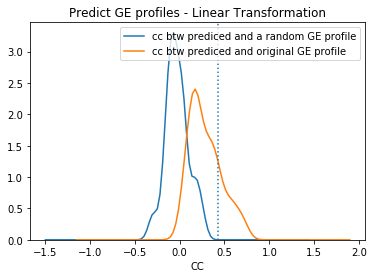

In [79]:
con=[]
nTestAlleles=20;
testAs=l1k.Allele.sample(nTestAlleles).tolist()
# testAs=['KRAS_p.G13D', 'RIT1_p.A77P', 'STK11_WT.c', 'STC2_WT.o',
#        'NFE2L2_WT.o', 'EGFR_p.ELREA746del', 'PIK3CA_p.123_124MP>IA',
#        'RBM10_p.G153C', 'STC2_p.R5W', 'SOX2_WT.o', 'STK11_WT.o',
#        'TPK1_p.T213S', 'PIK3CA_p.H1047R', 'BRAF_p.H574Q', 'STK11_p.H168R',
#        'NR4A2_p.R572G', 'MAP2K1_WT.c', 'RIT1_WT.c', 'TP53_p.E224D',
#        'PPP2R1A_p.W140C']


trainOverfit=0
con=[]


CP_m=cp.copy().reset_index(drop=True);

if 1:
    l1k_m=l1k.copy().reset_index(drop=True);
    sc = sklearn.preprocessing.StandardScaler()
    CP_m.iloc[CP_m.index,1:]=sc.fit_transform(CP_m.iloc[:,1:]);
    l1k_m.iloc[l1k_m.index,1:]=sc.fit_transform(l1k_m.iloc[:,1:]);


if trainOverfit:
    l1k_train=l1k_m.copy();l1k_test=l1k_m.copy()
    cp_train=CP_m.copy();cp_test=CP_m.copy()    
else:
    l1k_train=l1k_m[~l1k_m[pertColName].isin(testAs)].reset_index(drop=True)
    l1k_test=l1k_m[l1k_m[pertColName].isin(testAs)].reset_index(drop=True)

    cp_train=CP_m[~CP_m[pertColName].isin(testAs)].reset_index(drop=True)
    cp_test=CP_m[CP_m[pertColName].isin(testAs)].reset_index(drop=True)



# outdim_size=o;
pred=linearTransform2(l1k_train.iloc[:,1:].values,cp_train.iloc[:,1:].values,l1k_test.iloc[:,1:].values,cp_test.iloc[:,1:].values);


al1k_test=l1k_test.iloc[:,1:].values
al1k_train=l1k_train.iloc[:,1:].values

ccSame=[]
ccRandom=[]
for i in range(pred.shape[0]):
    ccSame.append(scipy.stats.pearsonr(pred[i,:], al1k_test[i,:])[0])
#     print(pred,al1k_test.shape,cc)
#     print(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1)),:].shape,al1k_test.shape)
    ccRandom.append(scipy.stats.pearsonr(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1))], al1k_test[i,:])[0])

    
    
    
title=['Predict GE profiles - Linear Transformation','GE features - Linear CCA']
fig, axes = plt.subplots()#(1,1,sharey='row', figsize=(12,6))
# sns.kdeplot(x)
i=0
sns.kdeplot(ccRandom, bw=.4, label="cc btw prediced and a random GE profile")
sns.kdeplot(ccSame, bw=.4, label="cc btw prediced and original GE profile");axes.set_xlabel('CC');
perc5=np.percentile(ccSame, 80);axes.axvline(x=perc5,linestyle=':');
axes.legend();axes.set_title(title[i]);

In [39]:
ccSame

[0.603530439700234,
 0.2658809278496993,
 0.4370466307595298,
 0.5512539440817329,
 0.6077702796796177,
 0.7007879165380262,
 0.2081700619006225,
 0.47895145620835716,
 0.25550478738606436,
 0.309214021230776,
 0.30599837057132945,
 0.5661003514813947,
 0.16502243469913475,
 0.3298917677195586,
 0.18110278032065308,
 0.5816759870134371,
 0.6142038958307343,
 0.44347685390519026,
 0.49033317274757465,
 0.37454149117336655]

In [42]:
ccRandom

[-0.04502139567477862,
 0.03955453095566366,
 0.06473973343701796,
 -0.015637142527741205,
 0.09479560670320789,
 0.07734433843288155,
 0.28772911963170983,
 0.21981144841336886,
 -0.02458398289045483,
 0.22847293758667567,
 0.35540310307819784,
 0.08197359568290329,
 0.11484034219683369,
 0.2618162226244338,
 0.2204234540177719,
 0.1925974256519627,
 -0.02735112294987142,
 0.15301514709027944,
 0.41462185444976846,
 -0.048555077076239336]

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/marziehhaghighi/rosetta-cp2ge/e4acd1a058e246c892f4f6f0c2f9d2d6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory [49]    : (12499615744.0, 12500664320.0)
COMET INFO:     sys.gpu.0.gpu_utilization [49]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (12796690432.0, 12796690432.0)
COMET INFO:     sys.gpu.0.used_memory [49]    : (296026112.0, 297074688.0)
COMET INFO:     sys.gpu.1.free_memory [49]    : (11488264192.0, 11488264192.0)
COMET INFO:     sys.gpu.1.gpu_utilization [49]: (0.0, 17.0)
COMET INFO:     sys.gpu.1.total_memory        : (12788498432.0, 12788498432.0)
COMET INFO:     sys.gpu.1.used_memory [49]    : (1300234240.0, 1300234240.0)
COMET INFO:     sys.gpu.2.free_memory [49]    : (12567248896.0, 12567248896.0)
COMET INFO:     sys.gpu.2.gpu_utilization [49]: (0.0, 0.0)
COMET INFO:     sys.gpu.2.

Total pairs: 505 (505, 291) (505, 978)
Total pairs: 20 (20, 291) (20, 978)
Epoch 1/300
5/5 [==============================] - 8s 2s/step - loss: 11.0785 - dense_56_loss: 1.0092 - dense_60_loss: 0.9865 - dense_56_mean_absolute_error: 1.0092 - dense_56_pcc: 0.9998 - dense_60_mean_absolute_error: 0.9865 - dense_60_pcc: 0.9978 - val_loss: 8.5578 - val_dense_56_loss: 0.7768 - val_dense_60_loss: 0.7897 - val_dense_56_mean_absolute_error: 0.7768 - val_dense_56_pcc: 0.9984 - val_dense_60_mean_absolute_error: 0.7897 - val_dense_60_pcc: 0.9559
Epoch 2/300
5/5 [==============================] - 0s 31ms/step - loss: 10.5330 - dense_56_loss: 0.9643 - dense_60_loss: 0.8903 - dense_56_mean_absolute_error: 0.9643 - dense_56_pcc: 0.9980 - dense_60_mean_absolute_error: 0.8903 - dense_60_pcc: 0.9705 - val_loss: 8.2963 - val_dense_56_loss: 0.7617 - val_dense_60_loss: 0.6797 - val_dense_56_mean_absolute_error: 0.7617 - val_dense_56_pcc: 0.9860 - val_dense_60_mean_absolute_error: 0.6797 - val_dense_60_pcc: 

5/5 [==============================] - 0s 30ms/step - loss: 7.9345 - dense_56_loss: 0.7368 - dense_60_loss: 0.5662 - dense_56_mean_absolute_error: 0.7368 - dense_56_pcc: 0.9243 - dense_60_mean_absolute_error: 0.5662 - dense_60_pcc: 0.6053 - val_loss: 6.9541 - val_dense_56_loss: 0.6406 - val_dense_60_loss: 0.5477 - val_dense_56_mean_absolute_error: 0.6406 - val_dense_56_pcc: 0.8275 - val_dense_60_mean_absolute_error: 0.5477 - val_dense_60_pcc: 0.5908
Epoch 19/300
5/5 [==============================] - 0s 35ms/step - loss: 7.5351 - dense_56_loss: 0.7006 - dense_60_loss: 0.5291 - dense_56_mean_absolute_error: 0.7006 - dense_56_pcc: 0.9090 - dense_60_mean_absolute_error: 0.5291 - dense_60_pcc: 0.5498 - val_loss: 6.9464 - val_dense_56_loss: 0.6403 - val_dense_60_loss: 0.5432 - val_dense_56_mean_absolute_error: 0.6403 - val_dense_56_pcc: 0.8291 - val_dense_60_mean_absolute_error: 0.5432 - val_dense_60_pcc: 0.5857
Epoch 20/300
5/5 [==============================] - 0s 27ms/step - loss: 7.8096

Epoch 36/300
5/5 [==============================] - 0s 31ms/step - loss: 7.5498 - dense_56_loss: 0.7012 - dense_60_loss: 0.5379 - dense_56_mean_absolute_error: 0.7012 - dense_56_pcc: 0.8941 - dense_60_mean_absolute_error: 0.5379 - dense_60_pcc: 0.6042 - val_loss: 6.5527 - val_dense_56_loss: 0.6065 - val_dense_60_loss: 0.4874 - val_dense_56_mean_absolute_error: 0.6065 - val_dense_56_pcc: 0.7814 - val_dense_60_mean_absolute_error: 0.4874 - val_dense_60_pcc: 0.5329
Epoch 37/300
5/5 [==============================] - 0s 24ms/step - loss: 7.5601 - dense_56_loss: 0.7011 - dense_60_loss: 0.5486 - dense_56_mean_absolute_error: 0.7011 - dense_56_pcc: 0.8960 - dense_60_mean_absolute_error: 0.5486 - dense_60_pcc: 0.5923 - val_loss: 6.5490 - val_dense_56_loss: 0.6063 - val_dense_60_loss: 0.4860 - val_dense_56_mean_absolute_error: 0.6063 - val_dense_56_pcc: 0.7813 - val_dense_60_mean_absolute_error: 0.4860 - val_dense_60_pcc: 0.5312
Epoch 38/300
5/5 [==============================] - 0s 30ms/step -

Epoch 54/300
5/5 [==============================] - 0s 28ms/step - loss: 7.6473 - dense_56_loss: 0.7049 - dense_60_loss: 0.5985 - dense_56_mean_absolute_error: 0.7049 - dense_56_pcc: 0.8732 - dense_60_mean_absolute_error: 0.5985 - dense_60_pcc: 0.6461 - val_loss: 6.4540 - val_dense_56_loss: 0.5984 - val_dense_60_loss: 0.4700 - val_dense_56_mean_absolute_error: 0.5984 - val_dense_56_pcc: 0.7719 - val_dense_60_mean_absolute_error: 0.4700 - val_dense_60_pcc: 0.5147
Epoch 55/300
5/5 [==============================] - 0s 27ms/step - loss: 7.3928 - dense_56_loss: 0.6837 - dense_60_loss: 0.5557 - dense_56_mean_absolute_error: 0.6837 - dense_56_pcc: 0.8632 - dense_60_mean_absolute_error: 0.5557 - dense_60_pcc: 0.5901 - val_loss: 6.4518 - val_dense_56_loss: 0.5983 - val_dense_60_loss: 0.4685 - val_dense_56_mean_absolute_error: 0.5983 - val_dense_56_pcc: 0.7719 - val_dense_60_mean_absolute_error: 0.4685 - val_dense_60_pcc: 0.5130
Epoch 56/300
5/5 [==============================] - 0s 26ms/step -

Epoch 72/300
5/5 [==============================] - 0s 29ms/step - loss: 7.3703 - dense_56_loss: 0.6821 - dense_60_loss: 0.5490 - dense_56_mean_absolute_error: 0.6821 - dense_56_pcc: 0.8656 - dense_60_mean_absolute_error: 0.5490 - dense_60_pcc: 0.5830 - val_loss: 6.4430 - val_dense_56_loss: 0.5971 - val_dense_60_loss: 0.4717 - val_dense_56_mean_absolute_error: 0.5971 - val_dense_56_pcc: 0.7699 - val_dense_60_mean_absolute_error: 0.4717 - val_dense_60_pcc: 0.5145
Epoch 73/300
5/5 [==============================] - 0s 23ms/step - loss: 7.2731 - dense_56_loss: 0.6732 - dense_60_loss: 0.5411 - dense_56_mean_absolute_error: 0.6732 - dense_56_pcc: 0.8685 - dense_60_mean_absolute_error: 0.5411 - dense_60_pcc: 0.5867 - val_loss: 6.4403 - val_dense_56_loss: 0.5973 - val_dense_60_loss: 0.4677 - val_dense_56_mean_absolute_error: 0.5973 - val_dense_56_pcc: 0.7703 - val_dense_60_mean_absolute_error: 0.4677 - val_dense_60_pcc: 0.5096
Epoch 74/300
5/5 [==============================] - 0s 31ms/step -

Epoch 90/300
5/5 [==============================] - 0s 26ms/step - loss: 7.3706 - dense_56_loss: 0.6841 - dense_60_loss: 0.5291 - dense_56_mean_absolute_error: 0.6841 - dense_56_pcc: 0.8718 - dense_60_mean_absolute_error: 0.5291 - dense_60_pcc: 0.5750 - val_loss: 6.3657 - val_dense_56_loss: 0.5915 - val_dense_60_loss: 0.4511 - val_dense_56_mean_absolute_error: 0.5915 - val_dense_56_pcc: 0.7583 - val_dense_60_mean_absolute_error: 0.4511 - val_dense_60_pcc: 0.4740
Epoch 91/300
5/5 [==============================] - 0s 32ms/step - loss: 7.3453 - dense_56_loss: 0.6801 - dense_60_loss: 0.5445 - dense_56_mean_absolute_error: 0.6801 - dense_56_pcc: 0.8605 - dense_60_mean_absolute_error: 0.5445 - dense_60_pcc: 0.5897 - val_loss: 6.3691 - val_dense_56_loss: 0.5916 - val_dense_60_loss: 0.4531 - val_dense_56_mean_absolute_error: 0.5916 - val_dense_56_pcc: 0.7583 - val_dense_60_mean_absolute_error: 0.4531 - val_dense_60_pcc: 0.4771
Epoch 92/300
5/5 [==============================] - 0s 26ms/step -

5/5 [==============================] - 0s 27ms/step - loss: 7.6827 - dense_56_loss: 0.7116 - dense_60_loss: 0.5665 - dense_56_mean_absolute_error: 0.7116 - dense_56_pcc: 0.8812 - dense_60_mean_absolute_error: 0.5665 - dense_60_pcc: 0.6051 - val_loss: 6.3479 - val_dense_56_loss: 0.5893 - val_dense_60_loss: 0.4552 - val_dense_56_mean_absolute_error: 0.5893 - val_dense_56_pcc: 0.7553 - val_dense_60_mean_absolute_error: 0.4552 - val_dense_60_pcc: 0.4737
Epoch 108/300
5/5 [==============================] - 0s 25ms/step - loss: 7.2493 - dense_56_loss: 0.6714 - dense_60_loss: 0.5352 - dense_56_mean_absolute_error: 0.6714 - dense_56_pcc: 0.8601 - dense_60_mean_absolute_error: 0.5352 - dense_60_pcc: 0.5681 - val_loss: 6.3461 - val_dense_56_loss: 0.5892 - val_dense_60_loss: 0.4540 - val_dense_56_mean_absolute_error: 0.5892 - val_dense_56_pcc: 0.7552 - val_dense_60_mean_absolute_error: 0.4540 - val_dense_60_pcc: 0.4718
Epoch 109/300
5/5 [==============================] - 0s 36ms/step - loss: 7.07

Epoch 125/300
5/5 [==============================] - 0s 25ms/step - loss: 7.2892 - dense_56_loss: 0.6754 - dense_60_loss: 0.5351 - dense_56_mean_absolute_error: 0.6754 - dense_56_pcc: 0.8626 - dense_60_mean_absolute_error: 0.5351 - dense_60_pcc: 0.5878 - val_loss: 6.3208 - val_dense_56_loss: 0.5870 - val_dense_60_loss: 0.4510 - val_dense_56_mean_absolute_error: 0.5870 - val_dense_56_pcc: 0.7505 - val_dense_60_mean_absolute_error: 0.4510 - val_dense_60_pcc: 0.4782
Epoch 126/300
5/5 [==============================] - 0s 25ms/step - loss: 7.1915 - dense_56_loss: 0.6675 - dense_60_loss: 0.5166 - dense_56_mean_absolute_error: 0.6675 - dense_56_pcc: 0.8559 - dense_60_mean_absolute_error: 0.5166 - dense_60_pcc: 0.5400 - val_loss: 6.3215 - val_dense_56_loss: 0.5872 - val_dense_60_loss: 0.4496 - val_dense_56_mean_absolute_error: 0.5872 - val_dense_56_pcc: 0.7511 - val_dense_60_mean_absolute_error: 0.4496 - val_dense_60_pcc: 0.4768
Epoch 127/300
5/5 [==============================] - 0s 33ms/ste

5/5 [==============================] - 0s 31ms/step - loss: 7.4239 - dense_56_loss: 0.6854 - dense_60_loss: 0.5696 - dense_56_mean_absolute_error: 0.6854 - dense_56_pcc: 0.8427 - dense_60_mean_absolute_error: 0.5696 - dense_60_pcc: 0.6041 - val_loss: 6.2706 - val_dense_56_loss: 0.5829 - val_dense_60_loss: 0.4414 - val_dense_56_mean_absolute_error: 0.5829 - val_dense_56_pcc: 0.7422 - val_dense_60_mean_absolute_error: 0.4414 - val_dense_60_pcc: 0.4526
Epoch 143/300
5/5 [==============================] - 0s 28ms/step - loss: 7.1772 - dense_56_loss: 0.6650 - dense_60_loss: 0.5272 - dense_56_mean_absolute_error: 0.6650 - dense_56_pcc: 0.8522 - dense_60_mean_absolute_error: 0.5272 - dense_60_pcc: 0.5629 - val_loss: 6.2721 - val_dense_56_loss: 0.5832 - val_dense_60_loss: 0.4397 - val_dense_56_mean_absolute_error: 0.5832 - val_dense_56_pcc: 0.7425 - val_dense_60_mean_absolute_error: 0.4397 - val_dense_60_pcc: 0.4494
Epoch 144/300
5/5 [==============================] - 0s 28ms/step - loss: 7.11

Epoch 160/300
5/5 [==============================] - 0s 28ms/step - loss: 6.8923 - dense_56_loss: 0.6400 - dense_60_loss: 0.4922 - dense_56_mean_absolute_error: 0.6400 - dense_56_pcc: 0.8486 - dense_60_mean_absolute_error: 0.4922 - dense_60_pcc: 0.5216 - val_loss: 6.2575 - val_dense_56_loss: 0.5815 - val_dense_60_loss: 0.4424 - val_dense_56_mean_absolute_error: 0.5815 - val_dense_56_pcc: 0.7408 - val_dense_60_mean_absolute_error: 0.4424 - val_dense_60_pcc: 0.4570
Epoch 161/300
5/5 [==============================] - 0s 28ms/step - loss: 6.8252 - dense_56_loss: 0.6317 - dense_60_loss: 0.5082 - dense_56_mean_absolute_error: 0.6317 - dense_56_pcc: 0.8256 - dense_60_mean_absolute_error: 0.5082 - dense_60_pcc: 0.5298 - val_loss: 6.2541 - val_dense_56_loss: 0.5810 - val_dense_60_loss: 0.4436 - val_dense_56_mean_absolute_error: 0.5810 - val_dense_56_pcc: 0.7397 - val_dense_60_mean_absolute_error: 0.4436 - val_dense_60_pcc: 0.4558
Epoch 162/300
5/5 [==============================] - 0s 30ms/ste

5/5 [==============================] - 0s 29ms/step - loss: 7.1878 - dense_56_loss: 0.6660 - dense_60_loss: 0.5278 - dense_56_mean_absolute_error: 0.6660 - dense_56_pcc: 0.8358 - dense_60_mean_absolute_error: 0.5278 - dense_60_pcc: 0.5375 - val_loss: 6.2329 - val_dense_56_loss: 0.5788 - val_dense_60_loss: 0.4453 - val_dense_56_mean_absolute_error: 0.5788 - val_dense_56_pcc: 0.7349 - val_dense_60_mean_absolute_error: 0.4453 - val_dense_60_pcc: 0.4565
Epoch 178/300
5/5 [==============================] - 0s 30ms/step - loss: 7.1925 - dense_56_loss: 0.6665 - dense_60_loss: 0.5280 - dense_56_mean_absolute_error: 0.6665 - dense_56_pcc: 0.8296 - dense_60_mean_absolute_error: 0.5280 - dense_60_pcc: 0.5600 - val_loss: 6.2277 - val_dense_56_loss: 0.5785 - val_dense_60_loss: 0.4430 - val_dense_56_mean_absolute_error: 0.5785 - val_dense_56_pcc: 0.7344 - val_dense_60_mean_absolute_error: 0.4430 - val_dense_60_pcc: 0.4554
Epoch 179/300
5/5 [==============================] - 0s 27ms/step - loss: 6.84

Epoch 195/300
5/5 [==============================] - 0s 30ms/step - loss: 7.0596 - dense_56_loss: 0.6514 - dense_60_loss: 0.5458 - dense_56_mean_absolute_error: 0.6514 - dense_56_pcc: 0.8310 - dense_60_mean_absolute_error: 0.5458 - dense_60_pcc: 0.5934 - val_loss: 6.2064 - val_dense_56_loss: 0.5766 - val_dense_60_loss: 0.4403 - val_dense_56_mean_absolute_error: 0.5766 - val_dense_56_pcc: 0.7301 - val_dense_60_mean_absolute_error: 0.4403 - val_dense_60_pcc: 0.4474
Epoch 196/300
5/5 [==============================] - 0s 41ms/step - loss: 7.0014 - dense_56_loss: 0.6515 - dense_60_loss: 0.4866 - dense_56_mean_absolute_error: 0.6515 - dense_56_pcc: 0.8171 - dense_60_mean_absolute_error: 0.4866 - dense_60_pcc: 0.4993 - val_loss: 6.2047 - val_dense_56_loss: 0.5763 - val_dense_60_loss: 0.4413 - val_dense_56_mean_absolute_error: 0.5763 - val_dense_56_pcc: 0.7304 - val_dense_60_mean_absolute_error: 0.4413 - val_dense_60_pcc: 0.4491
Epoch 197/300
5/5 [==============================] - 0s 33ms/ste

5/5 [==============================] - 0s 28ms/step - loss: 6.8918 - dense_56_loss: 0.6377 - dense_60_loss: 0.5152 - dense_56_mean_absolute_error: 0.6377 - dense_56_pcc: 0.8314 - dense_60_mean_absolute_error: 0.5152 - dense_60_pcc: 0.5836 - val_loss: 6.1711 - val_dense_56_loss: 0.5730 - val_dense_60_loss: 0.4412 - val_dense_56_mean_absolute_error: 0.5730 - val_dense_56_pcc: 0.7242 - val_dense_60_mean_absolute_error: 0.4412 - val_dense_60_pcc: 0.4437
Epoch 213/300
5/5 [==============================] - 0s 29ms/step - loss: 6.9311 - dense_56_loss: 0.6413 - dense_60_loss: 0.5184 - dense_56_mean_absolute_error: 0.6413 - dense_56_pcc: 0.8180 - dense_60_mean_absolute_error: 0.5184 - dense_60_pcc: 0.5959 - val_loss: 6.1675 - val_dense_56_loss: 0.5726 - val_dense_60_loss: 0.4414 - val_dense_56_mean_absolute_error: 0.5726 - val_dense_56_pcc: 0.7244 - val_dense_60_mean_absolute_error: 0.4414 - val_dense_60_pcc: 0.4425
Epoch 214/300
5/5 [==============================] - 0s 28ms/step - loss: 6.96

Epoch 230/300
5/5 [==============================] - 0s 29ms/step - loss: 6.7930 - dense_56_loss: 0.6312 - dense_60_loss: 0.4807 - dense_56_mean_absolute_error: 0.6312 - dense_56_pcc: 0.8127 - dense_60_mean_absolute_error: 0.4807 - dense_60_pcc: 0.5018 - val_loss: 6.1559 - val_dense_56_loss: 0.5708 - val_dense_60_loss: 0.4476 - val_dense_56_mean_absolute_error: 0.5708 - val_dense_56_pcc: 0.7204 - val_dense_60_mean_absolute_error: 0.4476 - val_dense_60_pcc: 0.4578
Epoch 231/300
5/5 [==============================] - 0s 29ms/step - loss: 6.9765 - dense_56_loss: 0.6479 - dense_60_loss: 0.4975 - dense_56_mean_absolute_error: 0.6479 - dense_56_pcc: 0.8481 - dense_60_mean_absolute_error: 0.4975 - dense_60_pcc: 0.5348 - val_loss: 6.1599 - val_dense_56_loss: 0.5714 - val_dense_60_loss: 0.4459 - val_dense_56_mean_absolute_error: 0.5714 - val_dense_56_pcc: 0.7214 - val_dense_60_mean_absolute_error: 0.4459 - val_dense_60_pcc: 0.4566
Epoch 232/300
5/5 [==============================] - 0s 26ms/ste

5/5 [==============================] - 0s 31ms/step - loss: 7.1131 - dense_56_loss: 0.6589 - dense_60_loss: 0.5242 - dense_56_mean_absolute_error: 0.6589 - dense_56_pcc: 0.8025 - dense_60_mean_absolute_error: 0.5242 - dense_60_pcc: 0.5485 - val_loss: 6.1245 - val_dense_56_loss: 0.5689 - val_dense_60_loss: 0.4359 - val_dense_56_mean_absolute_error: 0.5689 - val_dense_56_pcc: 0.7138 - val_dense_60_mean_absolute_error: 0.4359 - val_dense_60_pcc: 0.4407
Epoch 248/300
5/5 [==============================] - 0s 27ms/step - loss: 6.7665 - dense_56_loss: 0.6305 - dense_60_loss: 0.4611 - dense_56_mean_absolute_error: 0.6305 - dense_56_pcc: 0.8355 - dense_60_mean_absolute_error: 0.4611 - dense_60_pcc: 0.5058 - val_loss: 6.1219 - val_dense_56_loss: 0.5685 - val_dense_60_loss: 0.4365 - val_dense_56_mean_absolute_error: 0.5685 - val_dense_56_pcc: 0.7131 - val_dense_60_mean_absolute_error: 0.4365 - val_dense_60_pcc: 0.4420
Epoch 249/300
5/5 [==============================] - 0s 27ms/step - loss: 6.96

Epoch 265/300
5/5 [==============================] - 0s 40ms/step - loss: 6.5114 - dense_56_loss: 0.6044 - dense_60_loss: 0.4670 - dense_56_mean_absolute_error: 0.6044 - dense_56_pcc: 0.7945 - dense_60_mean_absolute_error: 0.4670 - dense_60_pcc: 0.5098 - val_loss: 6.0876 - val_dense_56_loss: 0.5650 - val_dense_60_loss: 0.4378 - val_dense_56_mean_absolute_error: 0.5650 - val_dense_56_pcc: 0.7073 - val_dense_60_mean_absolute_error: 0.4378 - val_dense_60_pcc: 0.4400
Epoch 266/300
5/5 [==============================] - 0s 27ms/step - loss: 6.7716 - dense_56_loss: 0.6270 - dense_60_loss: 0.5012 - dense_56_mean_absolute_error: 0.6270 - dense_56_pcc: 0.7968 - dense_60_mean_absolute_error: 0.5012 - dense_60_pcc: 0.5550 - val_loss: 6.0855 - val_dense_56_loss: 0.5648 - val_dense_60_loss: 0.4370 - val_dense_56_mean_absolute_error: 0.5648 - val_dense_56_pcc: 0.7071 - val_dense_60_mean_absolute_error: 0.4370 - val_dense_60_pcc: 0.4384
Epoch 267/300
5/5 [==============================] - 0s 25ms/ste

5/5 [==============================] - 0s 32ms/step - loss: 6.6762 - dense_56_loss: 0.6210 - dense_60_loss: 0.4664 - dense_56_mean_absolute_error: 0.6210 - dense_56_pcc: 0.8172 - dense_60_mean_absolute_error: 0.4664 - dense_60_pcc: 0.4928 - val_loss: 6.0934 - val_dense_56_loss: 0.5658 - val_dense_60_loss: 0.4359 - val_dense_56_mean_absolute_error: 0.5658 - val_dense_56_pcc: 0.7090 - val_dense_60_mean_absolute_error: 0.4359 - val_dense_60_pcc: 0.4358
Epoch 283/300
5/5 [==============================] - 0s 44ms/step - loss: 6.6592 - dense_56_loss: 0.6155 - dense_60_loss: 0.5046 - dense_56_mean_absolute_error: 0.6155 - dense_56_pcc: 0.7918 - dense_60_mean_absolute_error: 0.5046 - dense_60_pcc: 0.5284 - val_loss: 6.0886 - val_dense_56_loss: 0.5652 - val_dense_60_loss: 0.4366 - val_dense_56_mean_absolute_error: 0.5652 - val_dense_56_pcc: 0.7075 - val_dense_60_mean_absolute_error: 0.4366 - val_dense_60_pcc: 0.4379
Epoch 284/300
5/5 [==============================] - 0s 30ms/step - loss: 6.68

Epoch 300/300
5/5 [==============================] - 0s 30ms/step - loss: 6.9110 - dense_56_loss: 0.6376 - dense_60_loss: 0.5352 - dense_56_mean_absolute_error: 0.6376 - dense_56_pcc: 0.7690 - dense_60_mean_absolute_error: 0.5352 - dense_60_pcc: 0.5695 - val_loss: 6.0742 - val_dense_56_loss: 0.5639 - val_dense_60_loss: 0.4351 - val_dense_56_mean_absolute_error: 0.5639 - val_dense_56_pcc: 0.7066 - val_dense_60_mean_absolute_error: 0.4351 - val_dense_60_pcc: 0.4283


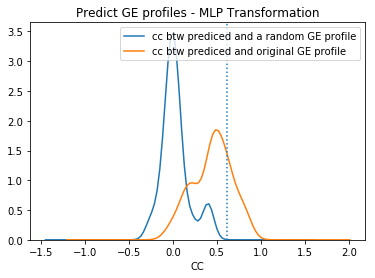

In [80]:
# prednn=nnTransform(l1k_train,cp_train,l1k_test,cp_test)
prednn=nnTransformWithCycle(l1k_train,cp_train,l1k_test,cp_test)
# pred=linearTransform2(l1k_train.iloc[:,1:].values,cp_train.iloc[:,1:].values,l1k_test.iloc[:,1:].values,cp_test.iloc[:,1:].values);


al1k_test=l1k_test.iloc[:,1:].values
al1k_train=l1k_train.iloc[:,1:].values

ccSame=[]
ccRandom=[]
for i in range(prednn.shape[0]):
    ccSame.append(scipy.stats.pearsonr(prednn[i,:], al1k_test[i,:])[0])
#     print(pred,al1k_test.shape,cc)
#     print(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1)),:].shape,al1k_test.shape)
    ccRandom.append(scipy.stats.pearsonr(al1k_train[np.random.choice(np.random.choice(al1k_train.shape[0],1))], al1k_test[i,:])[0])

    
    
    
title=['Predict GE profiles - MLP Transformation','GE features - Linear CCA']
fig, axes = plt.subplots()#(1,1,sharey='row', figsize=(12,6))
# sns.kdeplot(x)
i=0
sns.kdeplot(ccRandom, bw=.4, label="cc btw prediced and a random GE profile")
sns.kdeplot(ccSame, bw=.4, label="cc btw prediced and original GE profile");axes.set_xlabel('CC');
perc5=np.percentile(ccSame, 80);axes.axvline(x=perc5,linestyle=':');
axes.legend();axes.set_title(title[i]);

In [25]:
from numpy.linalg import inv
# Find the mapping between CP and L1k
def linearTransform2(al1k_train,acp_train,al1k_test,acp_test):
#     acp_train=np.concatenate((acp_train,np.ones((acp_train.shape[0],1))),axis=1);
# #     print(acp_test.shape)
#     acp_test=np.concatenate((acp_test,np.ones((acp_test.shape[0],1))),axis=1);
#     print(acp_test.shape)
    A=np.matmul(np.matmul(inv(np.matmul(np.transpose(acp_train),acp_train)),np.transpose(acp_train)),al1k_train)
    pred=np.matmul(acp_test,A)
#     print(pred[0].shape,al1k_test[0].shape)
#     print(np.random.choice(np.random.choice(al1k_train.shape[0],1)))
    return pred

In [69]:
prednn

[array([[ 0.15902606,  0.2626673 ,  1.7286433 , ...,  0.33442903,
          0.13566783,  0.2751713 ],
        [ 0.44441083,  0.29412115,  1.5514599 , ...,  0.33148676,
          0.34000477,  0.16403393],
        [-0.13344681,  0.0151739 ,  1.6012701 , ...,  0.13464531,
          0.26274958,  0.00216055],
        ...,
        [ 0.12183696,  0.28907394,  1.7855785 , ...,  0.3186058 ,
          0.17892945,  0.26805422],
        [ 0.16659224,  0.23726843,  1.8544022 , ...,  0.32495418,
          0.14458531,  0.2842976 ],
        [ 0.6238413 ,  0.5274172 ,  1.562999  , ...,  0.36907783,
          0.74396884,  0.11819728]], dtype=float32),
 array([[ 0.01809331,  0.23623118, -0.04638374, ..., -0.02350811,
         -0.03980228, -0.03550678],
        [ 0.01693312,  0.2359093 , -0.04540053, ..., -0.02331041,
         -0.03686656, -0.03262582],
        [ 0.00268733, -0.31978622,  0.04439288, ...,  0.01840543,
          0.02303808,  0.03930305],
        ...,
        [ 0.01611142,  0.22980365, -0.0

In [71]:
prednn[0]

array([[ 0.15902606,  0.2626673 ,  1.7286433 , ...,  0.33442903,
         0.13566783,  0.2751713 ],
       [ 0.44441083,  0.29412115,  1.5514599 , ...,  0.33148676,
         0.34000477,  0.16403393],
       [-0.13344681,  0.0151739 ,  1.6012701 , ...,  0.13464531,
         0.26274958,  0.00216055],
       ...,
       [ 0.12183696,  0.28907394,  1.7855785 , ...,  0.3186058 ,
         0.17892945,  0.26805422],
       [ 0.16659224,  0.23726843,  1.8544022 , ...,  0.32495418,
         0.14458531,  0.2842976 ],
       [ 0.6238413 ,  0.5274172 ,  1.562999  , ...,  0.36907783,
         0.74396884,  0.11819728]], dtype=float32)

In [ ]:
195.84/24

In [ ]:
Resss=pd.read_csv('../../results/results-Treatment.csv')

Resss.mean()

In [ ]:
Res

In [ ]:
Res.mean()

In [ ]:
Res

In [ ]:
Res

In [ ]:
l1k_m.Allele.tolist()

In [ ]:
Res.mean()

In [ ]:
ls

In [ ]:
Res2=Res.iloc[173:,:]
Res2.to_csv('results.csv' , index=False)

In [ ]:
l1k_m['Allele'].isin(a_train)

# Compute CCA

In [ ]:
# Preprocessing to the data:
# 1. Standardize features (z-scoring)
# 2. Reduce dimensionality (PCA down to 100 features)
# This is necessary because we only have 175 data points, 
# while L1000 has 978 features and Cell Painting has 256.
# So PCA is useful as a regularizer somehow.

def cca_analysis(GE_train, MF_train, GE_test, MF_test):
    # Prepare Gene Expression matrix
    sc_l1k = sklearn.preprocessing.StandardScaler()
    sc_l1k.fit(GE_train)
    GE = sc_l1k.transform(GE_train)
    
    pca_l1k = sklearn.decomposition.PCA(n_components=150, svd_solver="full")
    pca_l1k.fit(GE)
    GE = pca_l1k.transform(GE)

    # Prepare Cell Painting matrix
    sc_cp = sklearn.preprocessing.StandardScaler()
    sc_cp.fit(MF_train)
    MF = sc_cp.transform(MF_train)
    
    pca_cp = sklearn.decomposition.PCA(n_components=100, svd_solver="full")
    pca_cp.fit(MF)
    MF = pca_cp.transform(MF)

    # Compute CCA
    A, B, D, ma, mb = linear_cca.linear_cca(MF, GE, 10)
    
    X = pca_cp.transform(sc_cp.transform(MF_test))
    Y = pca_l1k.transform(sc_l1k.transform(GE_test))
    
    X = np.dot(X, A)
    Y = np.dot(Y, B)
    
    return X, Y, D

In [ ]:
GE = np.asarray(l1k)[:,1:]
MF = np.asarray(cp)[:,1:]
MF_v, GE_v, D = cca_analysis(GE, MF, GE, MF)

In [ ]:
# In linear CCA, the canonical correlations equal to the square roots of the eigenvalues:
plt.plot(np.sqrt(D))
print("First cannonical correlation: ", np.sqrt(D[0]))

In [ ]:
D = scipy.spatial.distance_matrix(MF_v[:,0:2], GE_v[:,0:2])
NN = np.argsort(D, axis=1) # Nearest morphology point to each gene expression point

plt.figure(figsize=(10,10))
plt.scatter(MF_v[:,0], MF_v[:,1], c="blue", s=50, edgecolor='gray', linewidths=1)
plt.scatter(GE_v[:,0]+0, GE_v[:,1]+0, c="lime", edgecolor='gray', linewidths=1)

connected = 0
for i in range(MF_v.shape[0]):
    for j in range(7): #GE_v.shape[0]):
        if cp.iloc[i].Allele == l1k.iloc[NN[i,j]].Allele:
            plt.plot([GE_v[NN[i,j],0],MF_v[i,0]],[GE_v[NN[i,j],1],MF_v[i,1]], 'k-', color="red")
#             if np.random.random() > 0.9:
#                 plt.text(GE_v[i,0], GE_v[i,1], l1k.iloc[i].Allele, horizontalalignment='left', size='medium', color='black')
            connected += 1
            #break

print(connected)
# plt.xlim(-2,2)
# plt.ylim(-2,2)

In [ ]:
df = pd.DataFrame(data={"cca1": np.concatenate((GE_v[:,0], MF_v[:,0])), 
                   "cca2": np.concatenate((GE_v[:,1],MF_v[:,1])),
                   "source": ["L1K" for x in range(GE_v.shape[0])]+["CP" for x in range(MF_v.shape[0])],
                   "allele": list(l1k["Allele"]) + list(cp["Allele"])}
                 )

In [ ]:
df["color"] = df["allele"].str.find("EGFR") != -1
sb.lmplot(data=df, x="cca1", y="cca2", hue="color", fit_reg=False, col="source")

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(MF_v[:,0], MF_v[:,1], c="blue", s=100, edgecolor='gray', linewidths=1)
plt.figure(figsize=(10,10))
plt.scatter(GE_v[:,0]+0, GE_v[:,1]+0, c="lime", s=100, edgecolor='gray', linewidths=1)

# Annotate visualization

In [ ]:
def visualize_annotations(l1k, cp, GE_v, MF_v, display_items=[]):
    ge_data = pd.DataFrame(data=l1k["Allele"].reset_index()) 
    ge_data["x"] = GE_v[:,0]
    ge_data["y"] = GE_v[:,1]
    ge_data.columns = ["idx", "Allele", "x", "y"]
    ge_data["type"] = "GeneExpression"
    
    mf_data = pd.DataFrame(data=cp["Allele"].reset_index())
    mf_data["x"] = MF_v[:,0]
    mf_data["y"] = MF_v[:,1]
    mf_data.columns = ["idx", "Allele", "x", "y"]
    mf_data["type"] = "Morphology"
    
    data = pd.concat([ge_data, mf_data])

    plt.figure(figsize=(12,12))
    p1 = sb.regplot(data=ge_data, x="x", y="y", fit_reg=False, color="red", scatter_kws={'s':50})
    p2 = sb.regplot(data=mf_data, x="x", y="y", fit_reg=False, color="blue", scatter_kws={'s':50})

    for point in range(ge_data.shape[0]):
        #if ge_data.Allele[point] in display_items:
        p1.text(ge_data.x[point], ge_data.y[point], ge_data.Allele[point], horizontalalignment='left', size='medium', color='black')

    for point in range(mf_data.shape[0]):
        #if mf_data.Allele[point] in display_items:
        p2.text(mf_data.x[point], mf_data.y[point], mf_data.Allele[point], horizontalalignment='left', size='medium', color='black')

In [ ]:
visualize_annotations(l1k, cp, GE_v, MF_v, display_items=["NFE2L2_p.T80K","EGFP"])

# Visualization in the test set

In [ ]:
common_alleles = set(cp["Allele"].unique()).intersection( l1k["Allele"].unique() )
genes = list(common_alleles)
np.random.shuffle(genes)

train = genes[0:9*int(len(genes)/10)]
test = genes[9*int(len(genes)/10):]

GE_train = np.asarray(l1k[l1k["Allele"].isin(train)])[:,1:]
MF_train = np.asarray(cp[cp["Allele"].isin(train)])[:,1:]

GE_test = np.asarray(l1k[l1k["Allele"].isin(test)])[:,1:]
MF_test = np.asarray(cp[cp["Allele"].isin(test)])[:,1:]

MF_v, GE_v, D = cca_analysis(GE_train, MF_train, GE_test, MF_test)

visualize_annotations(
    l1k[l1k["Allele"].isin(test)], 
    cp[cp["Allele"].isin(test)], 
    GE_v, 
    MF_v
)

In [ ]:
D = scipy.spatial.distance_matrix(MF_v[:,0:2], GE_v[:,0:2])
NN = np.argsort(D, axis=1) # Nearest morphology point to each gene expression point

plt.figure(figsize=(10,10))
plt.scatter(MF_v[:,0], MF_v[:,1], c="blue", s=50, edgecolor='gray', linewidths=1)
plt.scatter(GE_v[:,0]+0, GE_v[:,1]+0, c="red", edgecolor='gray', linewidths=1)

connected = 0
for i in range(MF_v.shape[0]):
    for j in range(7):
        if cp.iloc[i].Allele == l1k.iloc[NN[i,j]].Allele:
            plt.plot([GE_v[NN[i,j],0],MF_v[i,0]],[GE_v[NN[i,j],1],MF_v[i,1]], 'k-', color="lime")

In [ ]:
# In linear CCA, the canonical correlations equal to the square roots of the eigenvalues:
plt.plot(np.sqrt(D))
print("First cannonical correlation: ", np.sqrt(D[0]))

# Visualize data matrices

In [ ]:
X = (GE - np.min(GE))/(np.max(GE) - np.min(GE))
X = np.asarray(X, dtype=np.float32)
plt.imshow(X)

In [ ]:
X = (MF - np.min(MF))/(np.max(MF) - np.min(MF))
X = np.asarray(X, dtype=np.float32)
plt.imshow(X)